## 프로젝트 주요 목표 
* 2017년 서비스를 시작한 이래로 매출이 감소하고 있다. 
* 매출이 감소하는 주요 원인을 확인하고, 고객 획득/유지를 위한 인사이트를 도출한다. 
* 고객 데이터 기반으로 고객을 세분화하고, 세그멘테이션별 락인(Lock-in) 전략을 수립한다. 

* 데이터 출처 
  * [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)
  * 브라질 이커머스사 Olist Store의 주문 데이터 
  * 2016년 ~ 2018년 사이의 약 10만 건의 주문 건 

## 데이터 로드 및 개별 데이터 이해 

In [2]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [1]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

#레티나 디스플레이로 폰트가 선명하게 표시되도록 합니다.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install kaggle 
from google.colab import files 
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minaahayley","key":"2b9a4ddc90c33aadf0ac55ad9e6919df"}'}

In [4]:
!mkdir -p ~/.kaggle #create folder name Kaggle
!cp kaggle.json ~/.kaggle #copy kaggle.jason into folder Kaggle
!chmod 600 ~/.kaggle/kaggle.json #ignore Permission Warning 

%ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d olistbr/brazilian-ecommerce

!unzip brazilian-ecommerce.zip

 77% 33.0M/42.6M [00:00<00:00, 76.5MB/s]
100% 42.6M/42.6M [00:00<00:00, 89.5MB/s]
Archive:  brazilian-ecommerce.zip
  inflating: olist_customers_dataset.csv  
  inflating: olist_geolocation_dataset.csv  
  inflating: olist_order_items_dataset.csv  
  inflating: olist_order_payments_dataset.csv  
  inflating: olist_order_reviews_dataset.csv  
  inflating: olist_orders_dataset.csv  
  inflating: olist_products_dataset.csv  
  inflating: olist_sellers_dataset.csv  
  inflating: product_category_name_translation.csv  


In [6]:
!mkdir -p ~/.kaggle/datasets/brazilian-ecommerce #create folder name Kaggle

!cp olist_customers_dataset.csv ~/.kaggle/datasets/brazilian-ecommerce #copy into folder Kaggle 
!cp olist_geolocation_dataset.csv  ~/.kaggle/datasets/brazilian-ecommerce
!cp olist_order_items_dataset.csv  ~/.kaggle/datasets/brazilian-ecommerce
!cp olist_order_payments_dataset.csv  ~/.kaggle/datasets/brazilian-ecommerce
!cp olist_order_reviews_dataset.csv  ~/.kaggle/datasets/brazilian-ecommerce
!cp olist_orders_dataset.csv  ~/.kaggle/datasets/brazilian-ecommerce
!cp olist_products_dataset.csv  ~/.kaggle/datasets/brazilian-ecommerce
!cp olist_sellers_dataset.csv  ~/.kaggle/datasets/brazilian-ecommerce
!cp product_category_name_translation.csv  ~/.kaggle/datasets/brazilian-ecommerce

In [7]:
%ls ~/.kaggle/datasets/brazilian-ecommerce

olist_customers_dataset.csv       olist_orders_dataset.csv
olist_geolocation_dataset.csv     olist_products_dataset.csv
olist_order_items_dataset.csv     olist_sellers_dataset.csv
olist_order_payments_dataset.csv  product_category_name_translation.csv
olist_order_reviews_dataset.csv


In [8]:
customers = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/olist_customers_dataset.csv')
geolocation = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/olist_geolocation_dataset.csv')
items = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/olist_order_items_dataset.csv')
payments = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/olist_order_payments_dataset.csv')
reviews = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/olist_order_reviews_dataset.csv')
orders = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/olist_orders_dataset.csv')
products = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/olist_products_dataset.csv')
sellers = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/olist_sellers_dataset.csv') 
products_cat = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/product_category_name_translation.csv')

## (1) 세일즈 분석 

### Monthly Revenue 

In [9]:
orders = orders[~orders.order_status.isin(['unavailable', 'canceled'])]
orders = orders[(orders['order_purchase_timestamp'] >= '2017-01-01 00:00:00') & (orders['order_purchase_timestamp'] < '2018-09-01 00:00:00')]

df_revenue = orders[['order_id', 'order_purchase_timestamp']].merge(payments[['order_id', 'payment_value']], how='left', on='order_id')
df_revenue['year_month'] = pd.to_datetime(df_revenue.order_purchase_timestamp).dt.strftime('%Y-%m')
df_revenue = df_revenue.groupby('year_month')['payment_value'].sum().reset_index()
df_revenue.head()

,year_month,payment_value
0,2017-01,137006.76
1,2017-02,283621.94
2,2017-03,425656.40
3,2017-04,405988.38
4,2017-05,582926.16


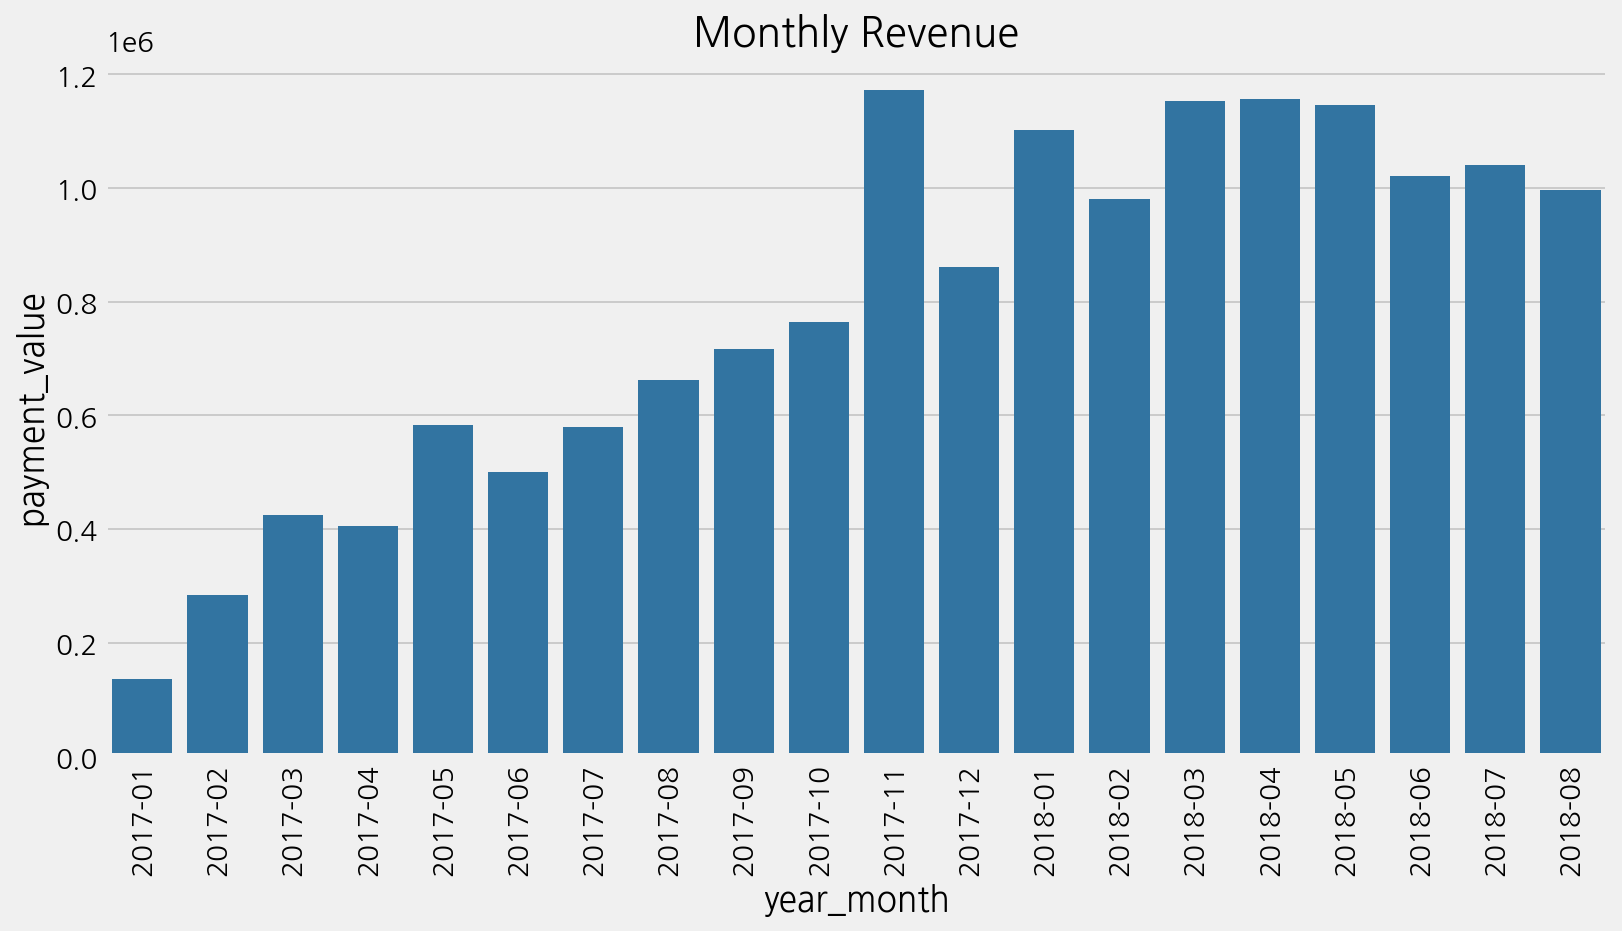

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='year_month', y='payment_value', data=df_revenue, color='tab:blue') 
ax.tick_params(axis='x', labelrotation=90)
plt.title('Monthly Revenue');

* 2017년 서비스가 시작한 이후 Monthly Revenue가 지속적으로 성장하다가,  
* 2017년 11월 최고점 판매 기록 이후 이후 매출이 정체되고 있다. 

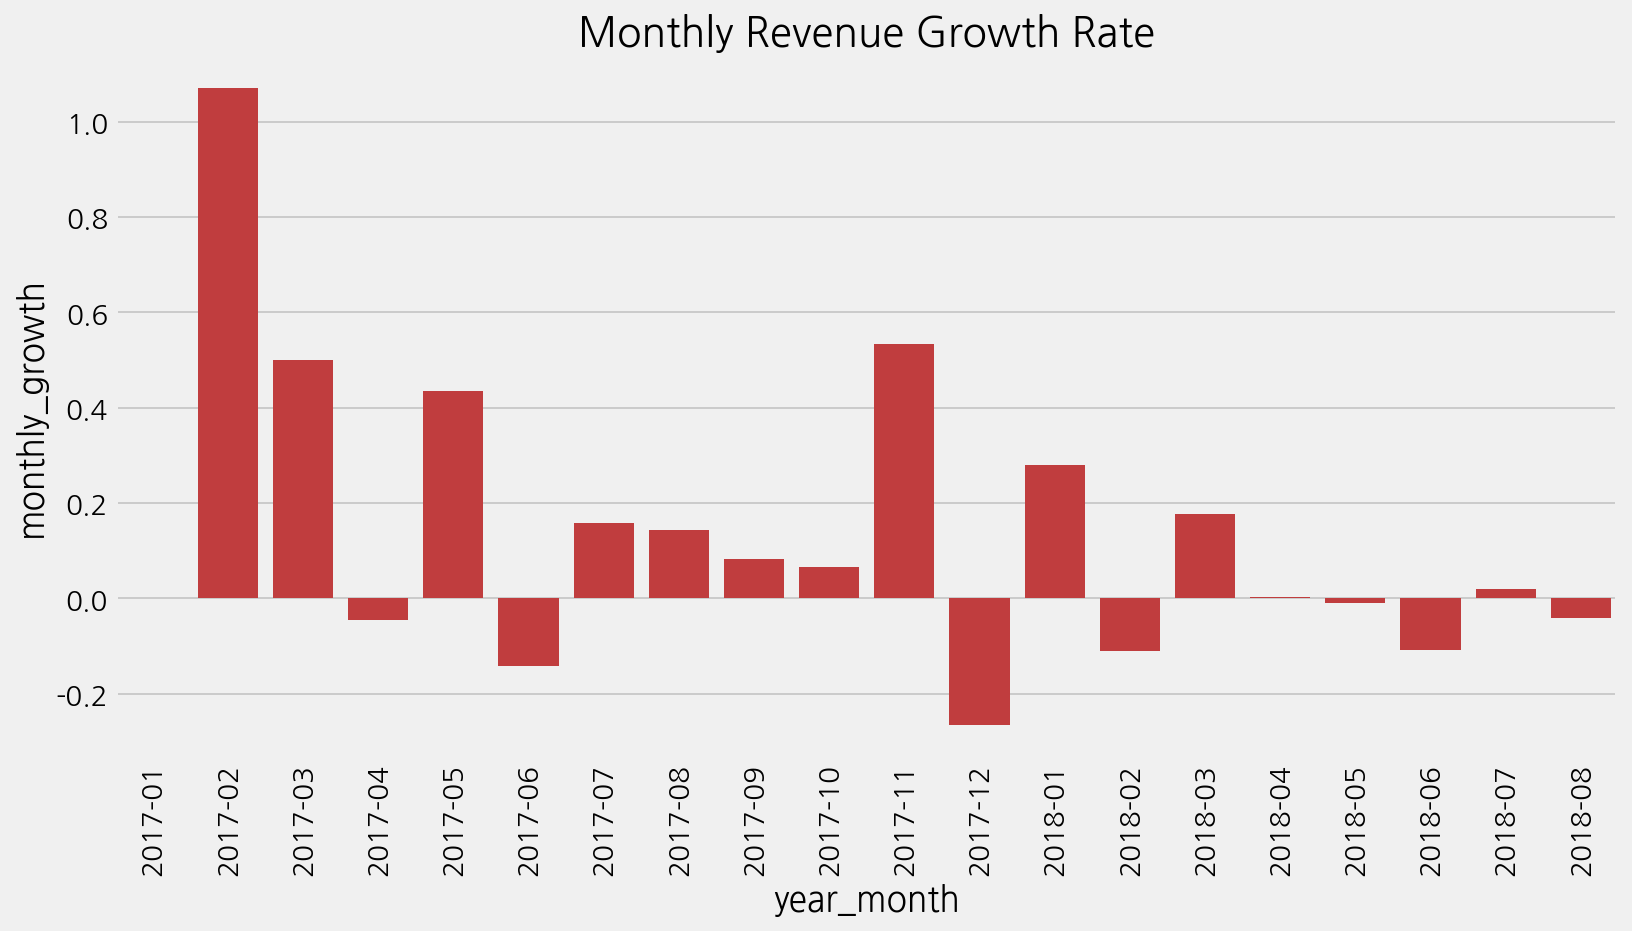

In [11]:
df_revenue['monthly_growth'] = df_revenue['payment_value'].pct_change()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='year_month', y='monthly_growth', data=df_revenue, color='tab:red') 
ax.tick_params(axis='x', labelrotation=90)
plt.title('Monthly Revenue Growth Rate');

* 2017년 11월 이후 매출이 정체된 이후, 전월 대비 성장률은 계속해서 하락하였다. 
* 특히, 2018년 9월 매출은 최저점을 기록하였다. 

### Monthly Active Customers 

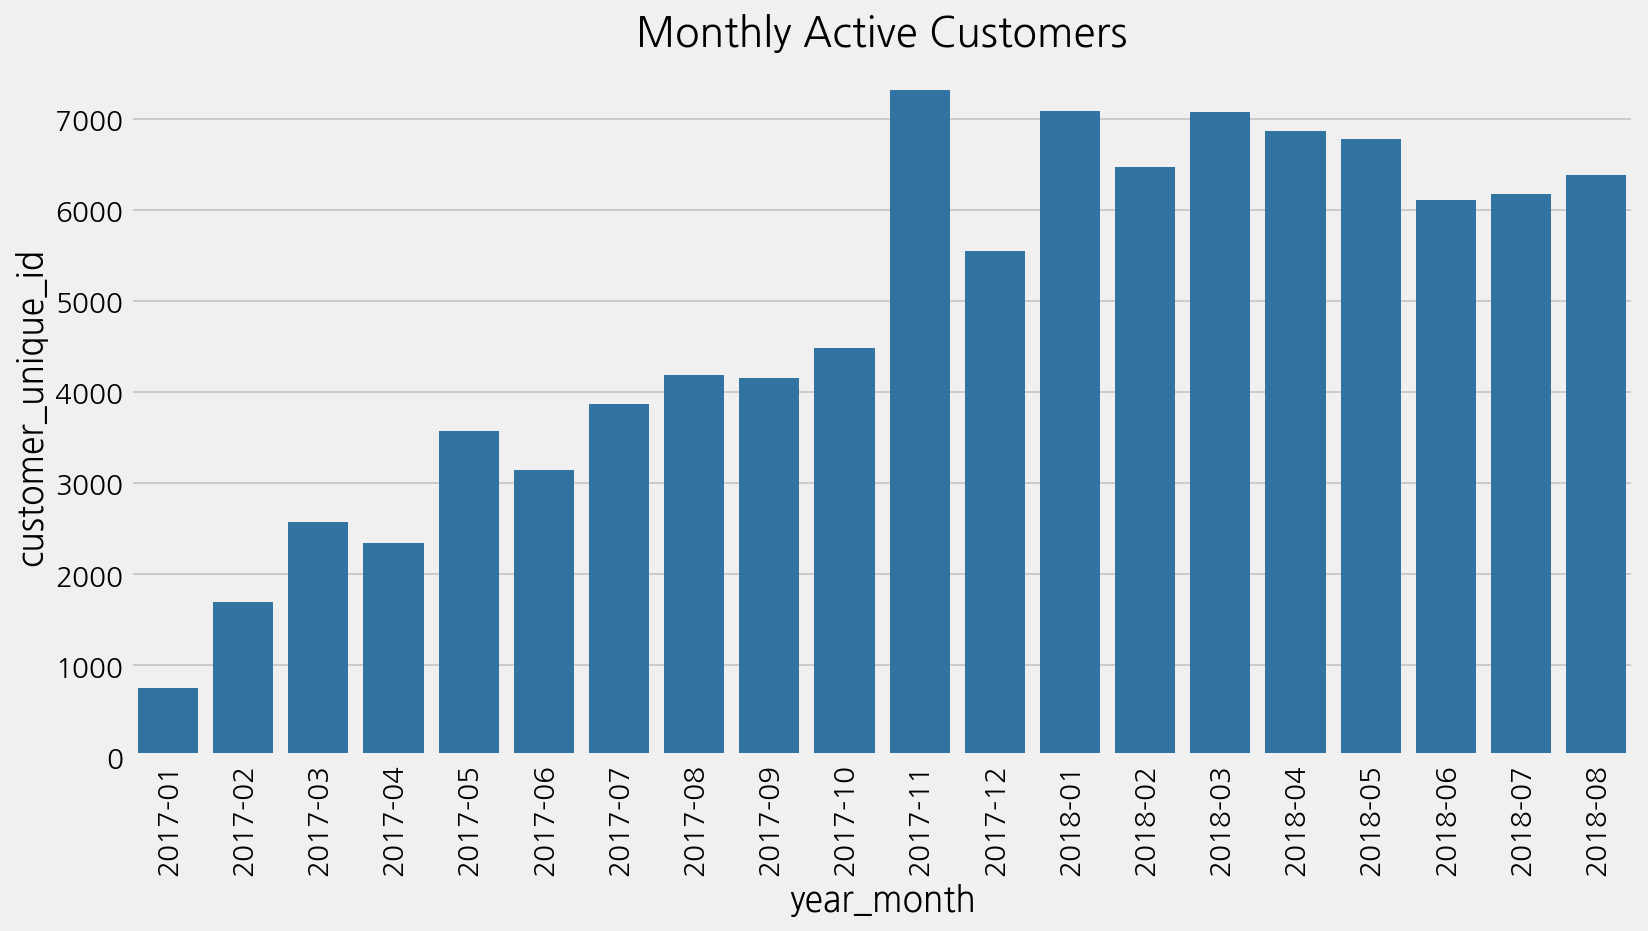

In [12]:
df = orders[['order_purchase_timestamp', 'customer_id']].merge(customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id')
df['year_month'] = pd.to_datetime(df.order_purchase_timestamp).dt.strftime('%Y-%m')
df_monthly_active = df.groupby('year_month')['customer_unique_id'].nunique().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='year_month', y='customer_unique_id', data=df_monthly_active, color='tab:blue') 
ax.tick_params(axis='x', labelrotation=90) 
plt.title('Monthly Active Customers');

* 2017년 11월 실 구매 유저는 7천명을 돌파하였으나, 이후 구매 유저 수가 소폭으로 감소하였다. 

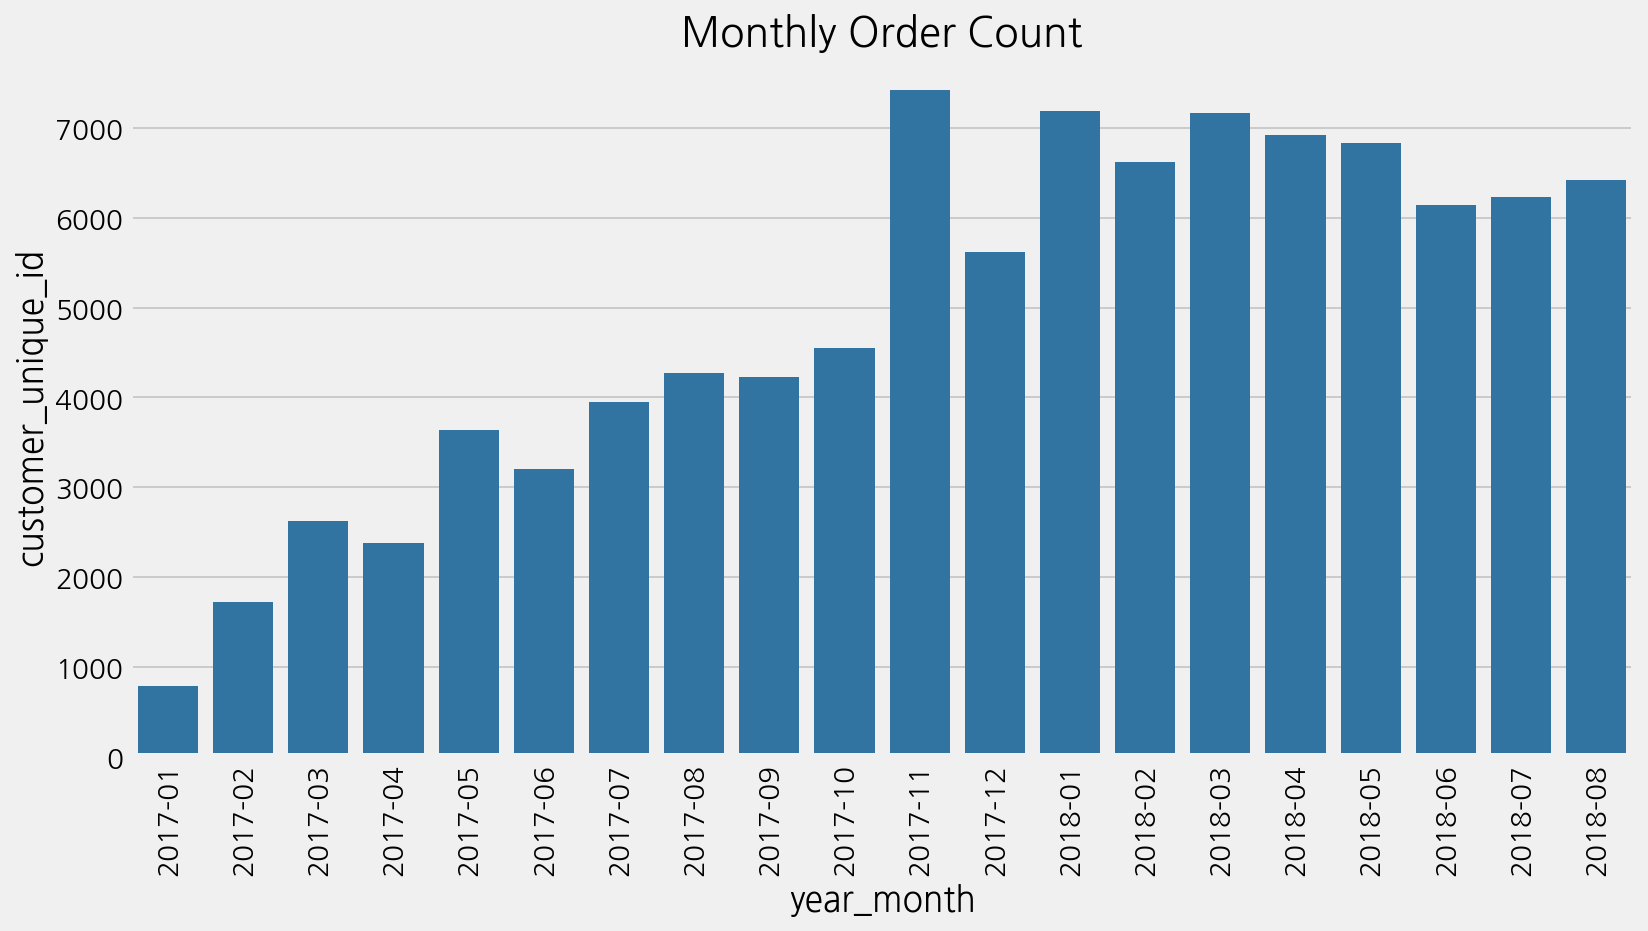

In [13]:
df_monthly_sales = df.groupby('year_month')['customer_unique_id'].count().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='year_month', y='customer_unique_id', data=df_monthly_sales, color='tab:blue') 
ax.tick_params(axis='x', labelrotation=90)
plt.title('Monthly Order Count');

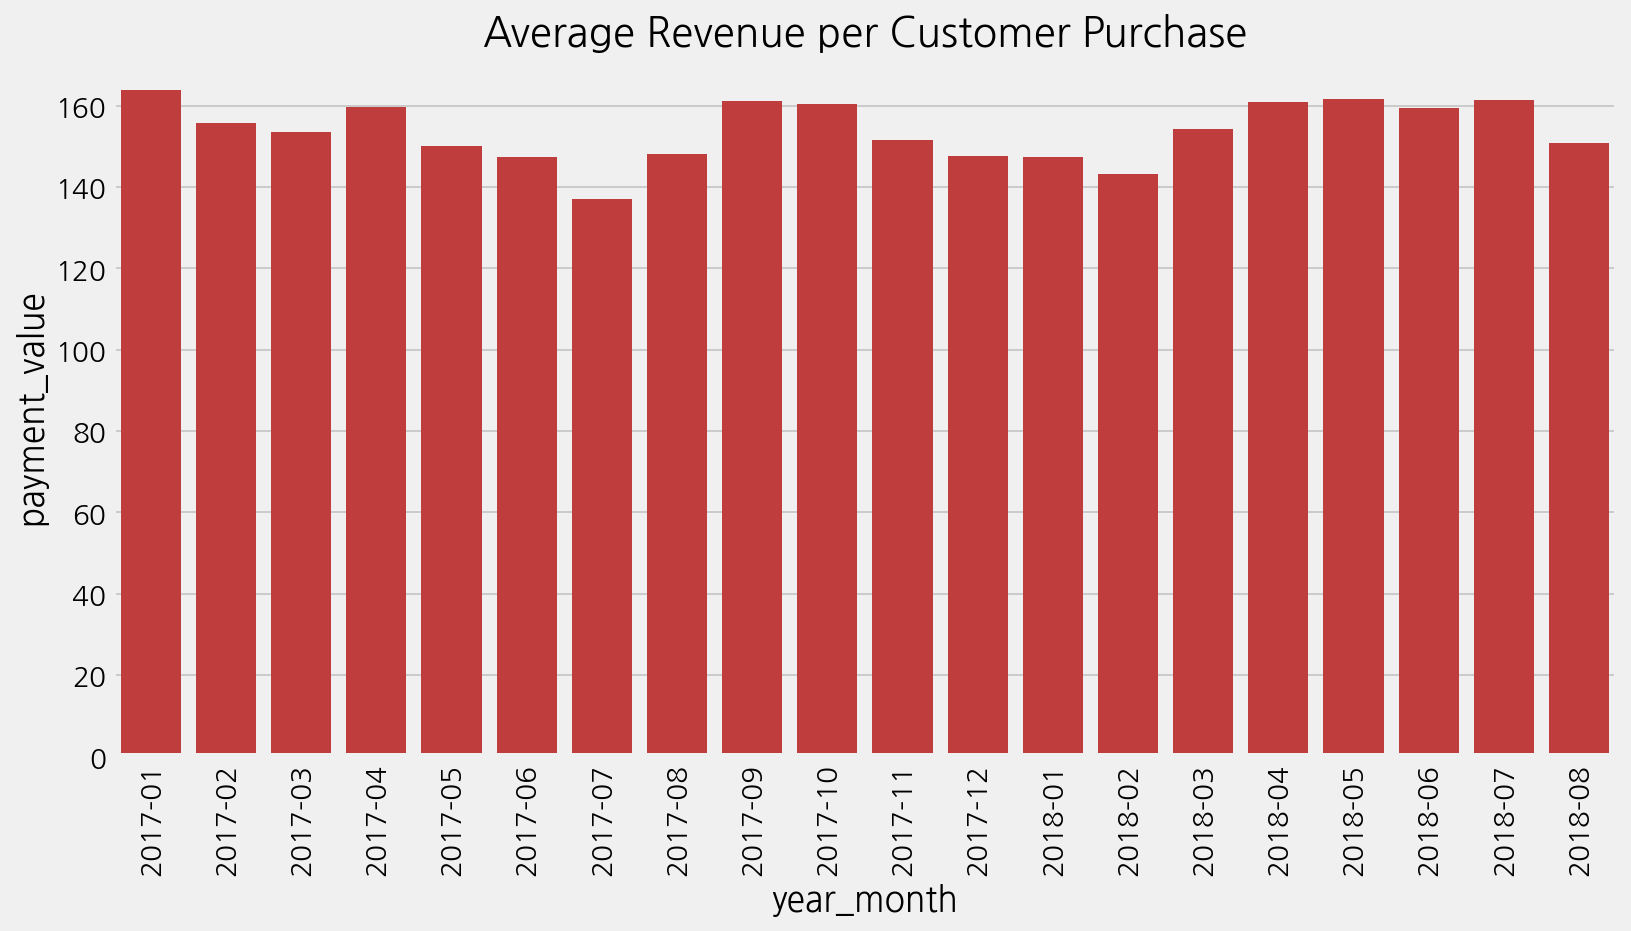

In [14]:
df = orders[['order_id', 'order_purchase_timestamp']].merge(payments[['order_id', 'payment_value']], how='left', on='order_id')
df['year_month'] = pd.to_datetime(df.order_purchase_timestamp).dt.strftime('%Y-%m')
df_monthly_order_avg = df.groupby('year_month')['payment_value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='year_month', y='payment_value', data=df_monthly_order_avg, color='tab:red') 
ax.tick_params(axis='x', labelrotation=90)
plt.title('Average Revenue per Customer Purchase');

* 월별 고객 수와 구매 수는 비례하며, 평균 인당 결제액은 160 브라질헤알에서 유지되고 있다.  

In [15]:
df = orders[['order_purchase_timestamp', 'customer_id', 'order_id']].merge(customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id')
df = df.merge(payments[['order_id', 'payment_value']], how='left', on='order_id')
df['year_month'] = pd.to_datetime(df.order_purchase_timestamp).dt.strftime('%Y-%m')
df = df.iloc[:, 3:]
df.head()

,customer_unique_id,payment_value,year_month
0,7c396fd4830fd04220f754e42b4e5bff,18.12,2017-10
1,7c396fd4830fd04220f754e42b4e5bff,2.00,2017-10
2,7c396fd4830fd04220f754e42b4e5bff,18.59,2017-10
3,af07308b275d755c9edb36a90c618231,141.46,2018-07
4,3a653a41f6f9fc3d2a113cf8398680e8,179.12,2018-08


In [16]:
df_first_order = df.groupby('customer_unique_id')['year_month'].min().reset_index()
df_first_order.columns = ['customer_unique_id', 'first_order_month']

df = df.merge(df_first_order, how='left', on='customer_unique_id')
df['usertype'] = 'New'
df.loc[df.first_order_month < df.year_month, 'usertype'] = 'Existing' 
df.head()

,customer_unique_id,payment_value,year_month,first_order_month,usertype
0,7c396fd4830fd04220f754e42b4e5bff,18.12,2017-10,2017-09,Existing
1,7c396fd4830fd04220f754e42b4e5bff,2.00,2017-10,2017-09,Existing
2,7c396fd4830fd04220f754e42b4e5bff,18.59,2017-10,2017-09,Existing
3,af07308b275d755c9edb36a90c618231,141.46,2018-07,2018-07,New
4,3a653a41f6f9fc3d2a113cf8398680e8,179.12,2018-08,2018-08,New


In [17]:
df_user_type_revenue = df.groupby(['year_month', 'usertype'])['payment_value'].sum().reset_index()
df_user_type_revenue.head()

,year_month,usertype,payment_value
0,2017-01,New,137006.76
1,2017-02,Existing,170.83
2,2017-02,New,283451.11
3,2017-03,Existing,650.82
4,2017-03,New,425005.58


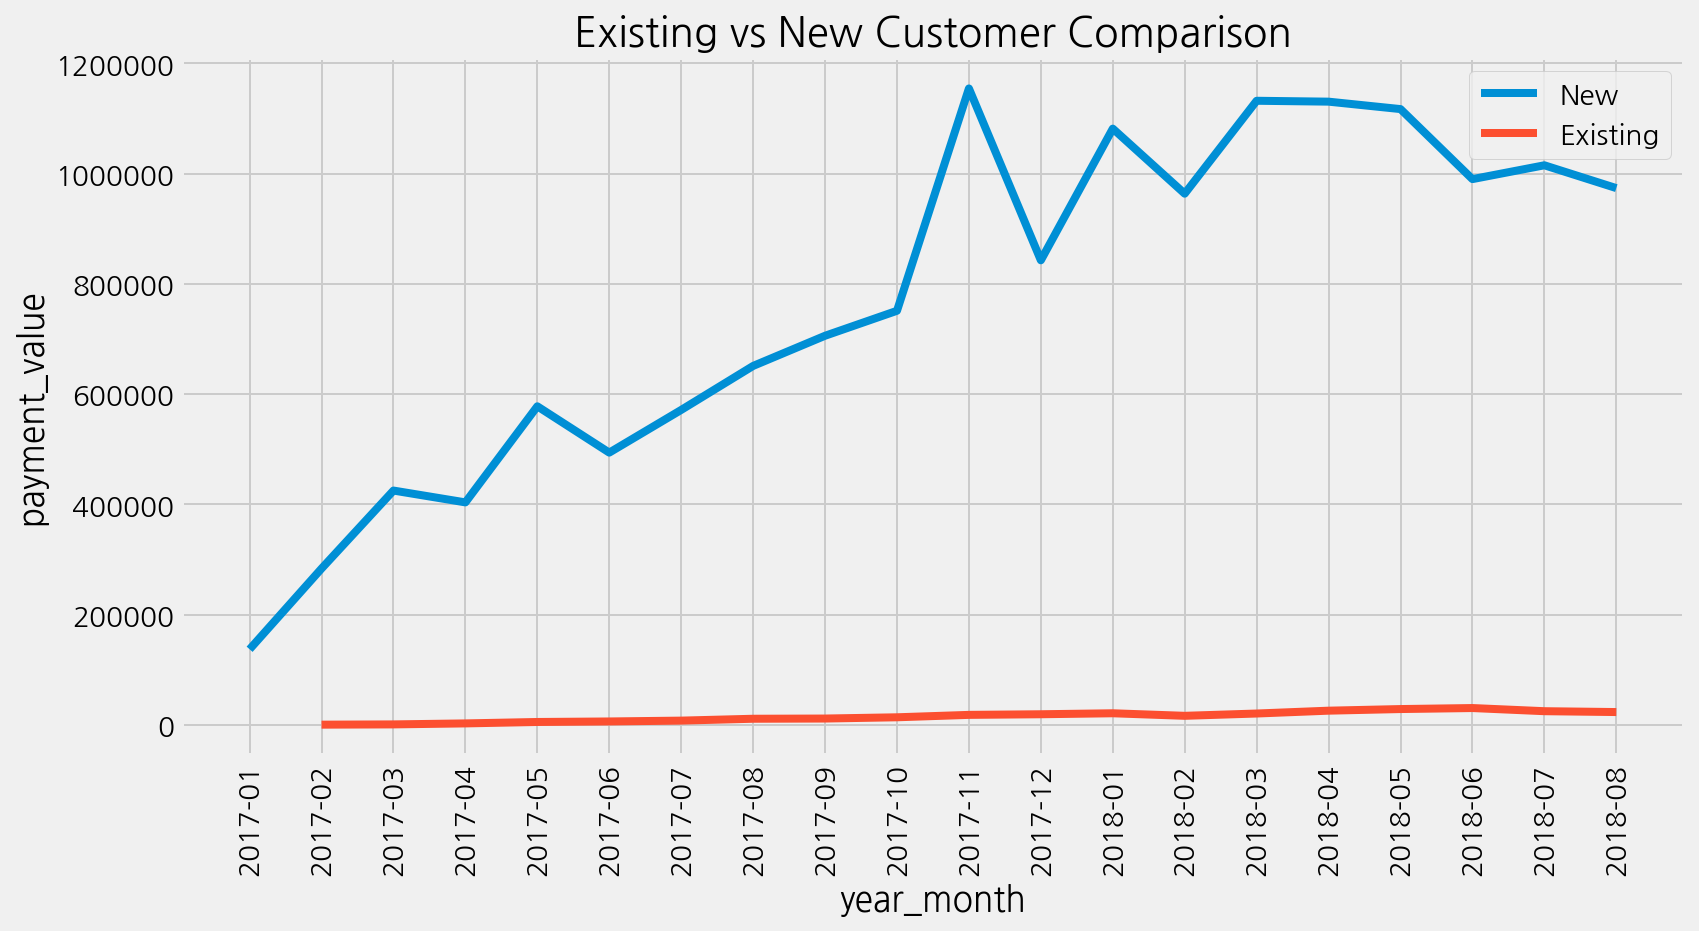

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.lineplot(data=df_user_type_revenue.query("usertype=='New'"), x='year_month', y='payment_value', label='New')
ax = sns.lineplot(data=df_user_type_revenue.query("usertype=='Existing'"), x='year_month', y='payment_value', label='Existing')
ax.set_title('Existing vs New Customer Comparison')
ax.tick_params(axis='x', labelrotation=90)

# 지수 표현 형식(Scientific Notation) 없애기 
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values]);

* 월별 신규 유저의 구매 금액이 대부분이고, 2017년 11월 최고점 기록 이후 소폭 하락하였다. 
* 기존 유저의 구매 금액은 거의 없다. 

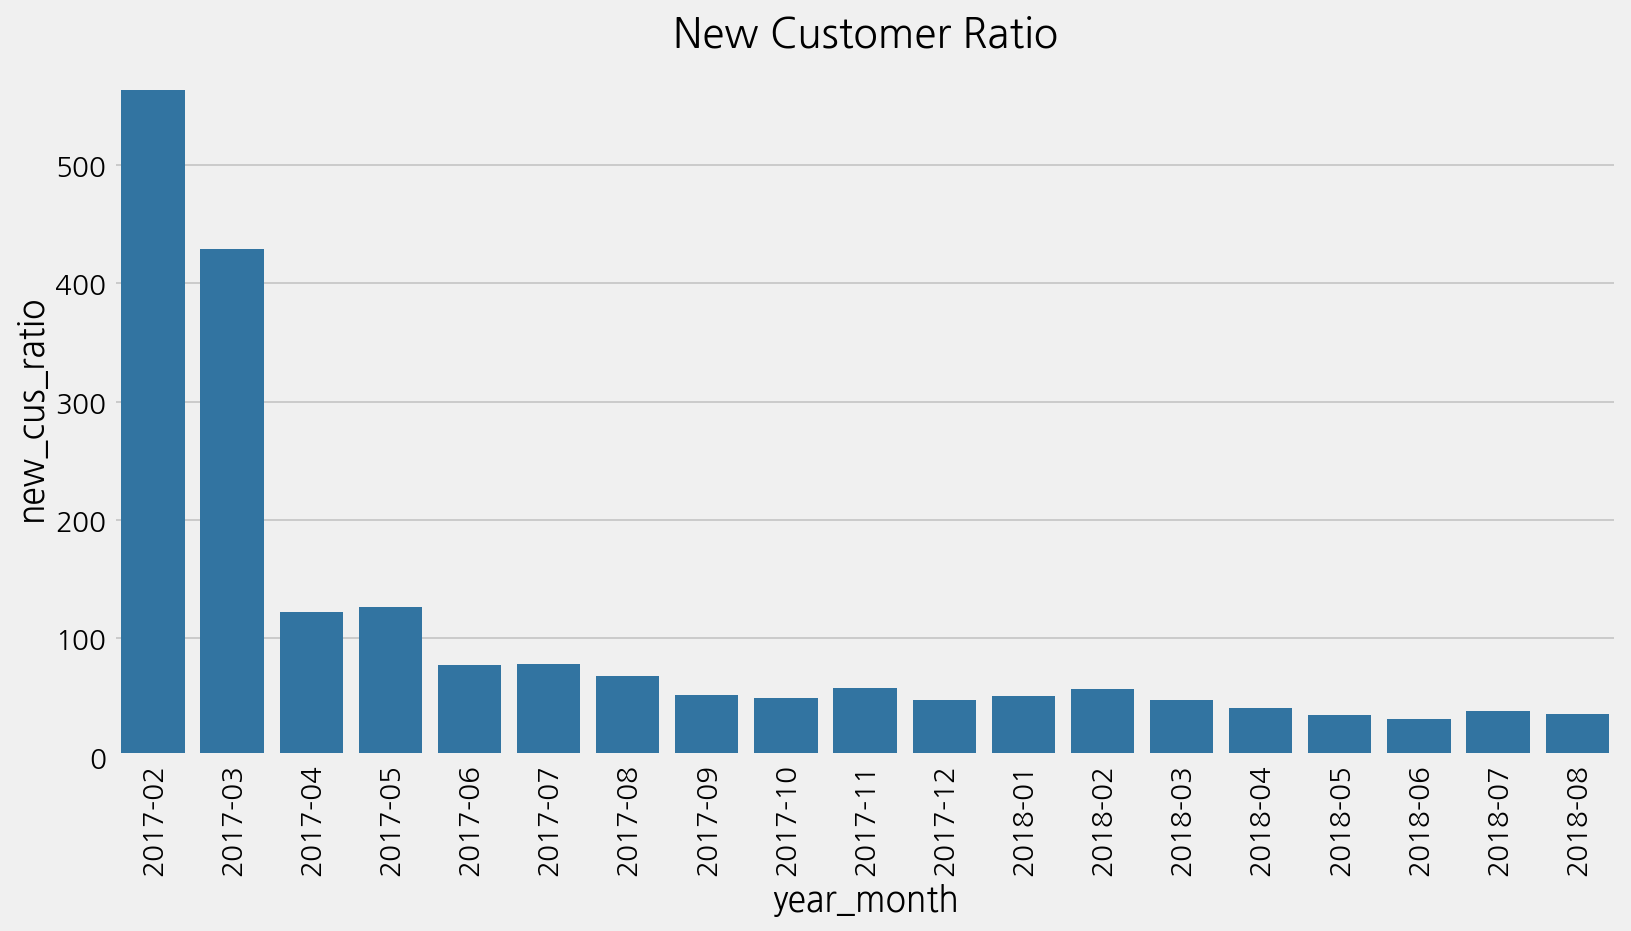

In [19]:
df_user_ratio = df.query('usertype=="New"').groupby('year_month')['customer_unique_id'].nunique()/df.query('usertype=="Existing"').groupby('year_month')['customer_unique_id'].nunique()
df_user_ratio = df_user_ratio.reset_index().dropna()
df_user_ratio.columns = ['year_month', 'new_cus_ratio']
df_user_ratio.head()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='year_month', y='new_cus_ratio', data=df_user_ratio, color='tab:blue') 
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('New Customer Ratio');

* 2017년 1분기 신규 유저가 급격하게 늘어난 이후, 월별 신규 유저의 비율은 지속적으로 감소하고 있다. 
* 월별 매출은 주로 신규 유저가 견인하는데, 매월 신규 유저 수가 감소한 것이 매출이 정체된 가장 큰 요인으로 보인다. 
* 기존 유저를 대상으로 한 재구매 전략과 신규 유저의 유입을 늘릴 수 있는 마케팅 전략을 동시에 고려해야 한다. 

### Monthly Retention Rate 

In [20]:
df['month_gap'] = round(((pd.to_datetime(df['year_month']) - pd.to_datetime(df['first_order_month'])).dt.days)/30, 0)

In [21]:
df_retention= df.groupby(['first_order_month', 'year_month','month_gap'])['customer_unique_id'].count().reset_index()
df_retention.columns = ['first_order_month', 'year_month', 'month_gap', 'activity_cnt']
df_retention.head()

,first_order_month,year_month,month_gap,activity_cnt
0,2017-01,2017-01,0.0,836
1,2017-01,2017-02,1.0,3
2,2017-01,2017-03,2.0,2
3,2017-01,2017-04,3.0,1
4,2017-01,2017-05,4.0,3


In [22]:
cohort = df_retention[df_retention.month_gap ==0][['first_order_month', 'activity_cnt']].rename(columns={'activity_cnt':'cohort_cnt'})
df_retention = df_retention.merge(cohort, how='left', on='first_order_month')
df_retention['retention_rate'] = round(df_retention['activity_cnt']/df_retention['cohort_cnt']*100,2)
df_retention.head()

,first_order_month,year_month,month_gap,activity_cnt,cohort_cnt,retention_rate
0,2017-01,2017-01,0.0,836,836,100.00
1,2017-01,2017-02,1.0,3,836,0.36
2,2017-01,2017-03,2.0,2,836,0.24
3,2017-01,2017-04,3.0,1,836,0.12
4,2017-01,2017-05,4.0,3,836,0.36


In [23]:
df_retention.pivot_table(index='first_order_month', columns='month_gap', values='retention_rate', fill_value=0).style.background_gradient(cmap = 'Blues')

month_gap,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0
first_order_month,,,,,,,,,,,,,,,,,,,
2017-01,100,0.360000,0.240000,0.120000,0.360000,0.120000,0.360000,0.120000,0.120000,0.000000,0.360000,0.120000,0.600000,0.360000,0.120000,0.120000,0.240000,0.360000,0.120000
2017-02,100,0.220000,0.280000,0.110000,0.390000,0.110000,0.220000,0.170000,0.110000,0.170000,0.110000,0.280000,0.110000,0.170000,0.110000,0.060000,0.060000,0.280000,0.000000
2017-03,100,0.510000,0.330000,0.580000,0.330000,0.140000,0.140000,0.330000,0.330000,0.070000,0.400000,0.110000,0.220000,0.110000,0.140000,0.250000,0.070000,0.140000,0.000000
2017-04,100,0.590000,0.240000,0.200000,0.320000,0.240000,0.440000,0.320000,0.280000,0.160000,0.240000,0.080000,0.080000,0.040000,0.080000,0.080000,0.160000,0.000000,0.000000
2017-05,100,0.490000,0.490000,0.360000,0.290000,0.420000,0.440000,0.160000,0.290000,0.290000,0.230000,0.310000,0.260000,0.030000,0.210000,0.290000,0.000000,0.000000,0.000000
2017-06,100,0.480000,0.360000,0.360000,0.270000,0.360000,0.390000,0.210000,0.150000,0.240000,0.330000,0.330000,0.150000,0.120000,0.210000,0.000000,0.000000,0.000000,0.000000
2017-07,100,1.030000,0.460000,0.220000,0.340000,0.190000,0.380000,0.100000,0.190000,0.260000,0.190000,0.310000,0.120000,0.240000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-08,100,0.680000,0.360000,0.250000,0.340000,0.550000,0.270000,0.250000,0.140000,0.140000,0.230000,0.180000,0.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-09,100,0.690000,0.530000,0.370000,0.500000,0.320000,0.210000,0.230000,0.270000,0.180000,0.300000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


* Monthly Retention이 1% 이하로 고객 유지율이 전반적으로 낮다.   
* 매월 코호트 기준, 6개월 전 유입 유저의 리텐션이 다시 반등하는 모습을 보인다. 
* 재결제 기간은 6개월로 유추 할 수 있다.

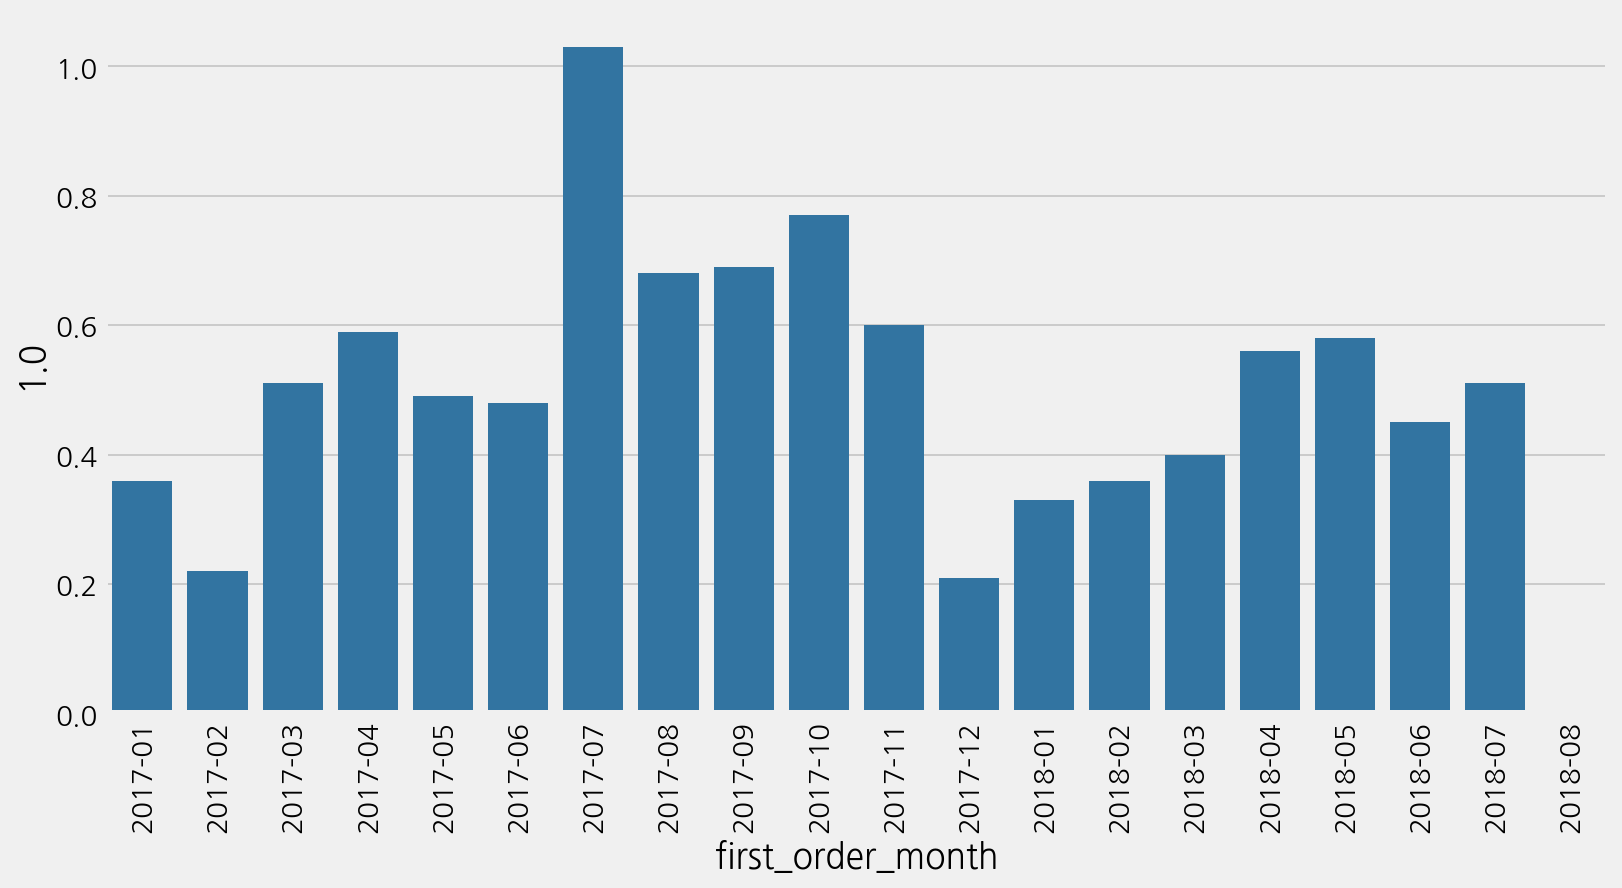

In [24]:
df_month1 = df_retention.pivot_table(index='first_order_month', columns='month_gap', values='retention_rate', fill_value=0)[1.00].reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='first_order_month', y=1.0, data=df_month1, color='tab:blue', ci=None)
ax.tick_params(axis='x', labelrotation=90);

* 신규 유저의 획득 뿐만 아니라, 기존 유저의 잔존율도 대폭 감소하였다. 

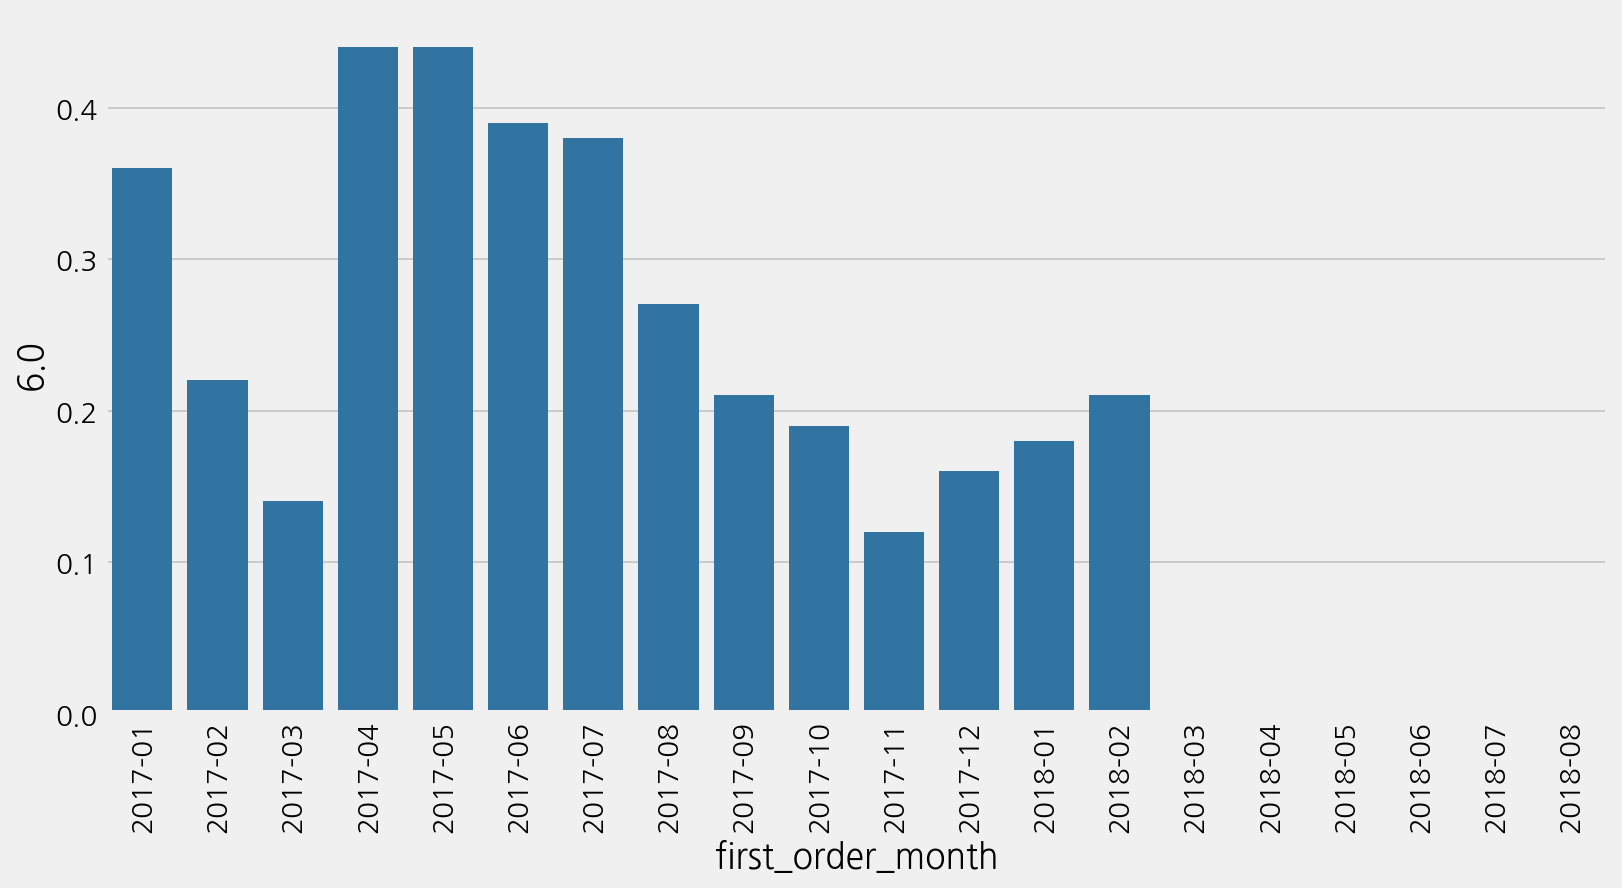

In [25]:
df_month6 = df_retention.pivot_table(index='first_order_month', columns='month_gap', values='retention_rate', fill_value=0)[6.00].reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='first_order_month', y=6.0, data=df_month6, color='tab:blue', ci=None)
ax.tick_params(axis='x', labelrotation=90);

* 특히 6개월 이후 재결제 유저의 잔존율은 17년 대비 18년 50% 이상 감소하였다. 

### 카테고리별 성장률  

In [81]:
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)

In [82]:
prod = products.merge(products_cat, on='product_category_name', how='left')[['product_id', 'product_category_name_english']]
prod.sample()

,product_id,product_category_name_english
23345,108dfaacffadeceb87032609d340722c,cool_stuff


In [83]:
items = items[['order_id', 'product_id']]
ds = items.merge(prod, how='left', on='product_id')
ds['order_id'].nunique(), ds['product_id'].nunique() 

(98666, 32951)

In [84]:
orders = orders.iloc[:, :4]
orders = orders[~orders.order_status.isin(['unavailable', 'canceled'])]
orders.sample()

,order_id,customer_id,order_status,order_purchase_timestamp
78451,5f332fa4ad3167e08253c656a2fae4cc,f092dc5c7219f24ce749882d2e11c43b,delivered,2018-05-20 21:14:51


In [85]:
payments = payments.groupby('order_id')['payment_value'].sum().reset_index()
payments.sample()

,order_id,payment_value
39318,654da57158d96035814657b5143bb11b,317.8


In [98]:
ds = ds.merge(orders, how='left', on='order_id').merge(payments, how='left', on='order_id')
ds = ds[['order_id','product_category_name_english','payment_value', 'order_purchase_timestamp' ]]
ds.sample()

,order_id,product_category_name_english,payment_value,order_purchase_timestamp
9806,1679d1eb7779b27771375628ff2f95f7,telephony,32.77,2017-11-24 09:33:45


In [99]:
ds['year'] = ds.order_purchase_timestamp.dt.year 
ds['quarter'] = ds.order_purchase_timestamp.dt.quarter 

In [100]:
ds['purchase_fiscal'] = ds['quarter'].apply(lambda x : '1st half' if x ==1 or x==2 else '2st half')

In [101]:
ds['purchase_fiscal'] = ds['purchase_fiscal'] + '_' + ds['year'].astype(str).str.split('.', expand=True)[0]

In [102]:
ds = ds.groupby(['product_category_name_english','purchase_fiscal']).agg({'payment_value':'sum', 'order_id':'nunique'}).reset_index()

In [103]:
ds = ds[ds.purchase_fiscal.isin(['1st half_2018', '1st half_2017'])]

In [104]:
ds = ds.pivot(index='product_category_name_english', columns='purchase_fiscal', values=['payment_value','order_id']).reset_index()
ds.columns = ['cat_name', 'sales_1st_2017', 'sales_1st_2018', 'cnt_1st_2017', 'cnt_1st_2018'] 

In [105]:
ds = ds.dropna()

In [106]:
ds = ds[['cat_name', 'cnt_1st_2017', 'sales_1st_2017', 'cnt_1st_2018', 'sales_1st_2018']]

In [107]:
ds['arppu_2017'] = ds['sales_1st_2017']/ds['cnt_1st_2017']
ds['arppu_2018'] = ds['sales_1st_2018']/ds['cnt_1st_2018'] 
ds['growth_rate(%)'] =( ds['sales_1st_2018'] - ds['sales_1st_2017'] )/ ds['sales_1st_2017']

In [96]:
top10 = ds.sort_values(by='growth_rate(%)', ascending=False).head(10) 
top10

,cat_name,cnt_1st_2017,sales_1st_2017,cnt_1st_2018,sales_1st_2018,arppu_2017,arppu_2018,growth_rate(%)
64,small_appliances_home_oven_and_coffee,1.0,88.65,40.0,40735.10,88.650000,1018.377500,458.504794
17,construction_tools_construction,12.0,2903.95,420.0,139342.59,241.995833,331.768071,46.983812
19,construction_tools_safety,3.0,822.62,92.0,39195.42,274.206667,426.037174,46.647055
12,christmas_supplies,3.0,435.86,59.0,12510.83,145.286667,212.047966,27.703781
50,industry_commerce_and_business,7.0,1311.36,175.0,37519.34,187.337143,214.396229,27.611015
24,drinks,8.0,2188.67,180.0,58042.13,273.583750,322.456278,25.519361
62,signaling_and_security,9.0,2030.10,70.0,35033.85,225.566667,500.483571,16.257204
10,books_technical,9.0,878.05,160.0,13194.65,97.561111,82.466562,14.027219
13,cine_photo,5.0,466.17,41.0,6459.69,93.234000,157.553415,12.856941
14,computers,2.0,5820.46,40.0,77025.09,2910.230000,1925.627250,12.233506


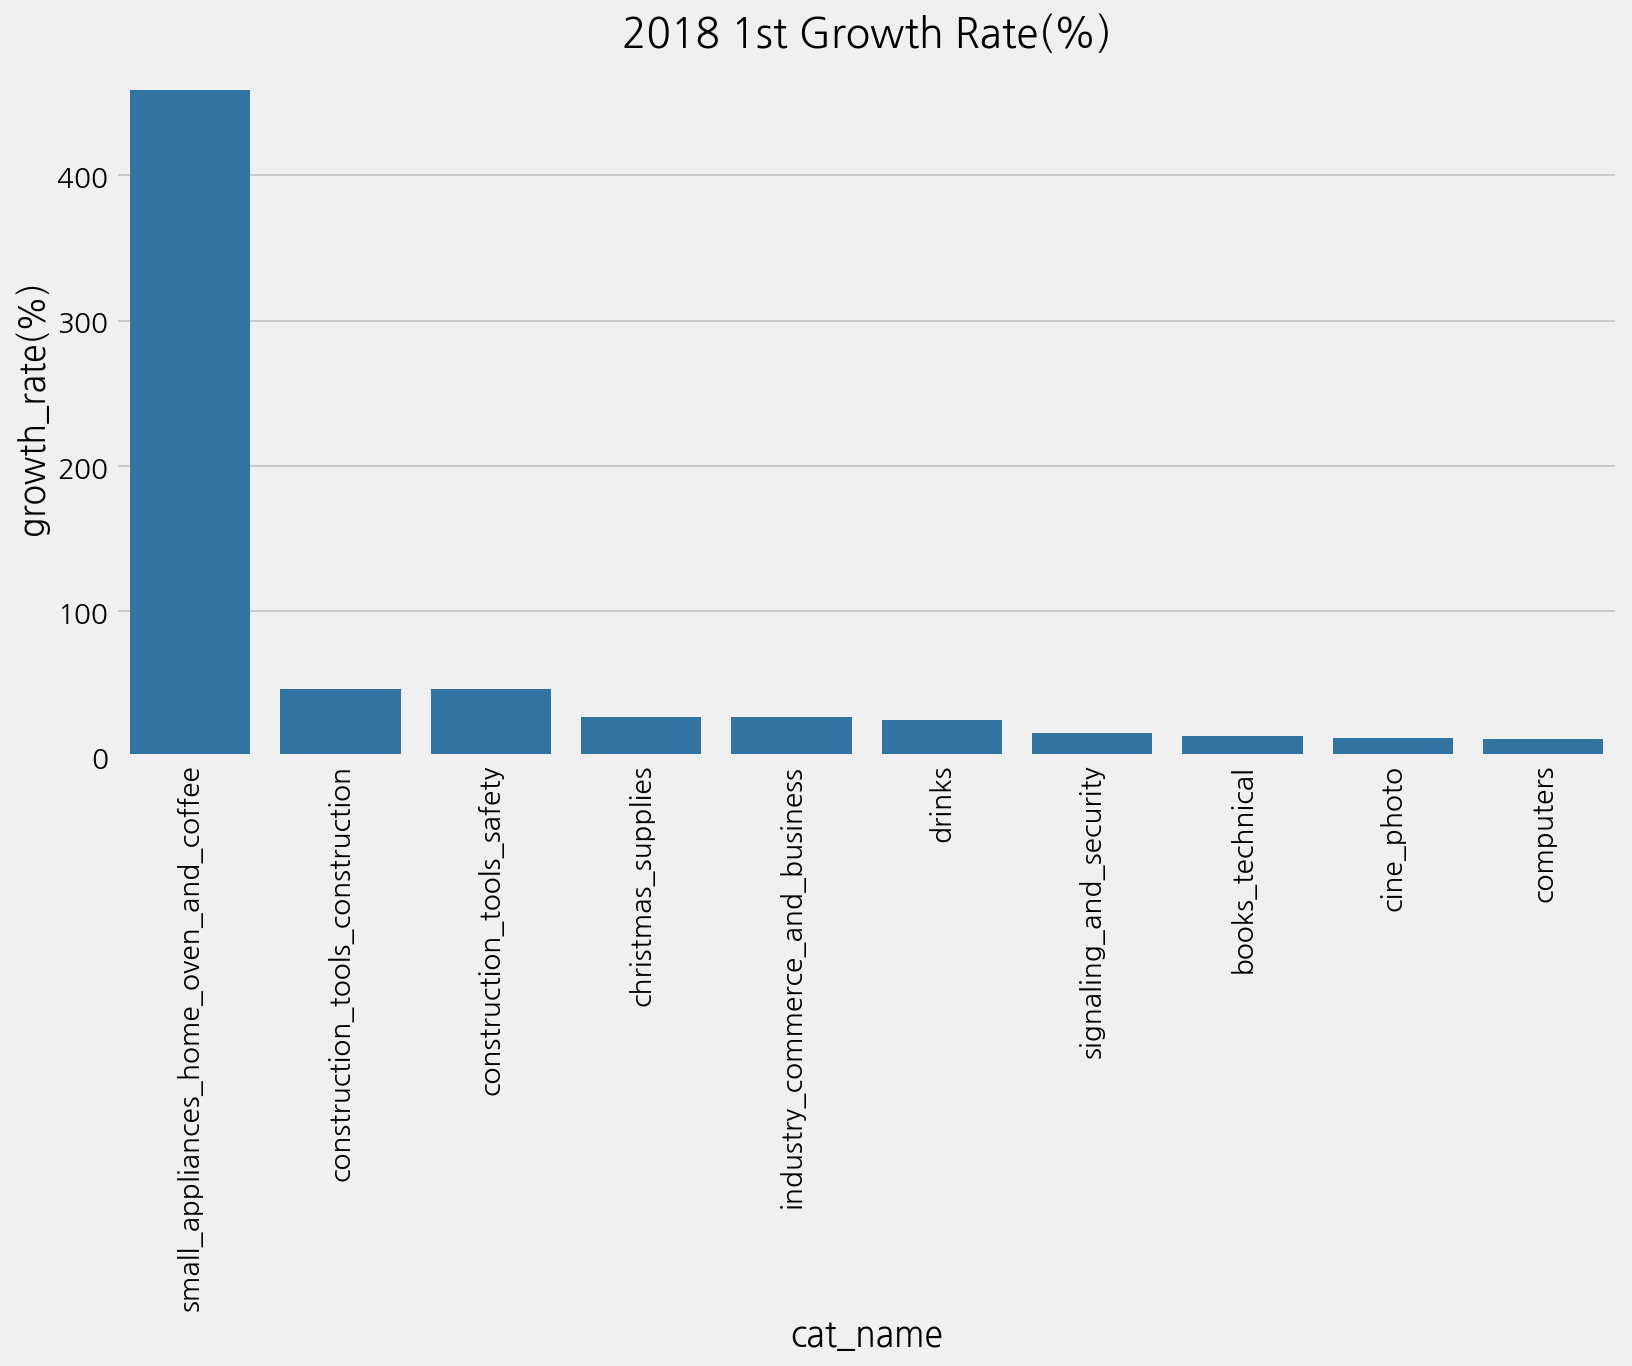

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='cat_name', y='growth_rate(%)', data=top10, color='tab:blue', ci=None)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('2018 1st Growth Rate(%)');

* small_appliances_home_oven_and_coffee가 폭발적인 성장률 (45850.47%)를 보인 이유는 다음과 같다. 

  * 2017년 상반기에는 한 사람만이 구매하였고, 2018년 상반기에는 40명이 구매하였다. 
  * 고객당 평균 구매금액은 88.65 브라질헤알에서 1018.37 브라질헤알로 1048.76% 성장하였다. 분석을 추가한다면 다음과 같은 경우를 고려할 수 있을 것으로 보인다. 
  * 이 경우 해당 카테고리 내에서 가격이 높은 특정 제품이 인기를 끌었거나, 
  * 몇 사람이 굉장히 비싼 제품을 구매했을 것으로 판단된다. 

## (2) RFM 분석 

In [43]:
customers = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/olist_customers_dataset.csv')
items = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/olist_order_items_dataset.csv')
payments = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/olist_order_payments_dataset.csv')
orders = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/olist_orders_dataset.csv')
products = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/olist_products_dataset.csv')
products_cat = pd.read_csv('~/.kaggle/datasets/brazilian-ecommerce/product_category_name_translation.csv')

In [44]:
orders = orders[~orders.order_status.isin(['unavailable', 'canceled'])]
ds = orders[['customer_id', 'order_id', 'order_purchase_timestamp']].merge(customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id')

In [45]:
ds = ds.iloc[:, 1:]
ds['order_date'] = pd.to_datetime(ds.order_purchase_timestamp).dt.strftime('%Y-%m-%d')
ds.head()

,order_id,order_purchase_timestamp,customer_unique_id,order_date
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13


In [46]:
ds1 = ds.groupby('customer_unique_id').agg({'order_date':['max', 'count']}).reset_index()
ds1.columns=['customer_unique_id', 'R', 'F']

In [47]:
ds2 = ds.merge(payments[['order_id', 'payment_value']], how='left', on='order_id')
ds2 = ds2.groupby('customer_unique_id')['payment_value'].sum().reset_index()
ds2.columns=['customer_unique_id', 'M']

In [48]:
ds3 = ds1.merge(ds2, how='left', on='customer_unique_id')
ds3['R'] = pd.to_datetime(ds3['R'])
ds3['R'] = ds3['R'].apply(lambda x : ds3.R.max() - x) 
ds3['R'] = ds3['R'].dt.days.astype(int)

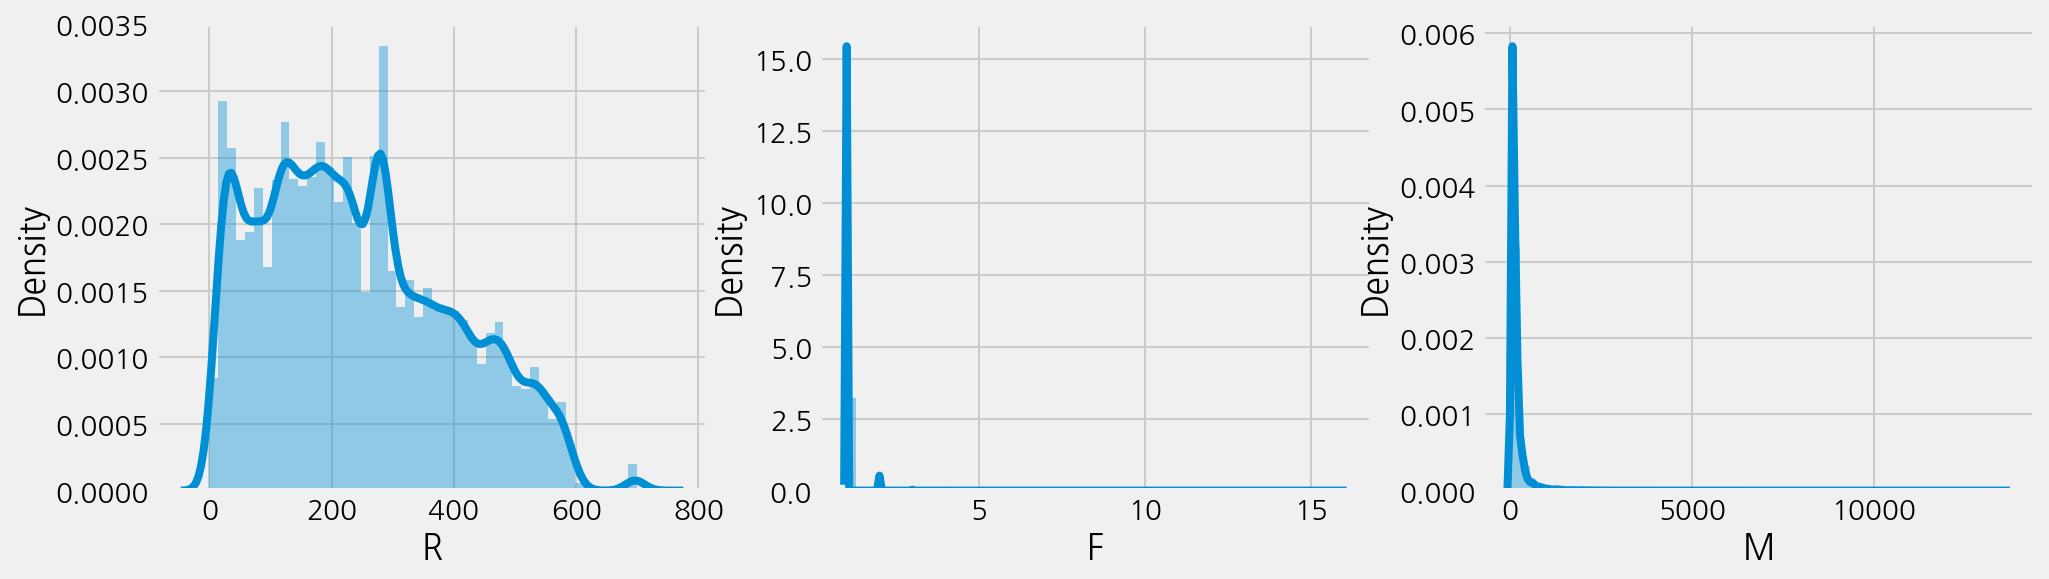

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes = axes.flatten()

for col, ax in zip(['R', 'F', 'M'], axes):
  sns.distplot(ds3[col], ax=ax)

특히 F, M의 경우 치우침이 심해보인다.

또한 추후 K-Means clustering을 이용할 것인데, 이 경우 관측치간의 거리를 이용하므로 단위가 결과에 큰 영향을 미친다.

따라서 각 변수들에 대해 표준화 작업을 수행하도록 한다.

### RFM 점수화 (범위: 1~5점) 

퍼센타일에 따라서 각 변수에 대하여 1~5의 범위로 라벨링을 수행하였다. 

다만, F의 경우 거의 모든 빈도수가 1이기 때문에 F는 두 그룹으로 나뉜다. 

결과적으로 5x2x5=50개의 그룹핑이 된다. 

In [50]:
# recency는 작을수록 점수가 크다 
ds3['R_score'] = pd.qcut(ds3['R'], 5, labels = [5, 4, 3, 2, 1]).astype(str)

ds3['F_score'] = ds3['F'].apply(lambda x : '1' if x==1 else '2')

ds3['M_score'] = pd.qcut(ds3['M'], 5, labels = [1,2,3,4,5]).astype(str)

In [51]:
# f를 제외하고 거의 균등하게 라벨링이 수행되었다. 
print('R_score')
print(ds3['R_score'].value_counts(normalize=True))

print('\nF_score')
print(ds3['F_score'].value_counts(normalize=True))

print('\nM_score')
print(ds3['M_score'].value_counts(normalize=True))

R_score
5    0.201421
3    0.200095
1    0.199695
4    0.199516
2    0.199274
Name: R_score, dtype: float64

F_score
1    0.969597
2    0.030403
Name: F_score, dtype: float64

M_score
1    0.200042
4    0.200021
2    0.200000
5    0.199979
3    0.199958
Name: M_score, dtype: float64


RFM 분석에서 단순히 R,F,M을 더하여 고객을 구분하는 것보다는 가중치를 이용하여 최종 RFM 점수를 도출하는 것이 중요하다. 

회사나 산업의 특성에 따라 다음과 같이 개별 R,F,M에 따른 각기 다른 고객 프로파일링을 하는 것이 중요하다. 

* R,F,M(1,1,5) : 이 고객은 한 번의 대량 구매 후 이탈했을 가능성이 높다. 
* R,F,M(5,5,5) : 이 고객은 회사의 VVIP이다. 
* R,F,M(5,5,2) : 이 고객은 구매금액은 적은 편이지만, 충성고객일 가능성이 높다. 
* R,F,M(5,1,5) : 최근에 가입하였고, 구매금액이 큰 것으로 보아 매우 중요한 고객이며, 향후 VVIP가 될 가능성이 높은 고객이기 때문에 이러한 고객은 별도로 트래킹하며 관리할 필요가 있다. 

In [52]:
# 다음과 같은 고객은 이미 서비스를 이탈했을 가능성이 높다고 판단된다. 
ds3[(ds3.R_score <='2') & (ds3.M_score >='3')]

,customer_unique_id,R,F,M,R_score,F_score,M_score
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,2,1,4
8,0005e1862207bf6ccc02e4228effd9a0,548,1,150.12,1,1,4
11,00082cbe03e478190aadbea78542e933,288,1,126.26,2,1,3
14,000a5ad9c4601d2bbdd9ed765d5213b3,388,1,91.28,2,1,3
18,000de6019bb59f34c099a907c151d855,382,1,257.44,2,1,5
...,...,...,...,...,...,...,...
94962,ffebb6424578e7bb153322da9d65634f,595,1,665.70,1,1,5
94970,ffef0ffa736c7b3d9af741611089729b,462,1,139.07,1,1,4
94975,fff3a9369e4b7102fab406a334a678c3,388,1,102.74,2,1,3
94985,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,2067.42,1,1,5


### 고객 클러스터링 

In [53]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score 
from yellowbrick.cluster import KElbowVisualizer 
from mpl_toolkits.mplot3d import Axes3D 

In [54]:
# 0~1 사이를 반환하는 MinMax 스케일링을 수행한다. 

scaler = MinMaxScaler()

rfm_data_cluster = ds3[['R', 'F', 'M']]

rfm_data_scaled = scaler.fit_transform(rfm_data_cluster)
rfm_data_scaled

array([[0.15912209, 0.        , 0.01038489],
       [0.16323731, 0.        , 0.00198989],
       [0.74348422, 0.        , 0.00630997],
       ...,
       [0.78600823, 0.        , 0.00823034],
       [0.17009602, 0.        , 0.00978405],
       [0.67078189, 0.        , 0.00523709]])

In [55]:
rfm_data_scaled = pd.DataFrame(rfm_data_scaled, columns=['R', 'F', 'M'])
rfm_data_scaled.head()

,R,F,M
0,0.159122,0.0,0.010385
1,0.163237,0.0,0.001990
2,0.743484,0.0,0.006310
3,0.447188,0.0,0.003192
4,0.401920,0.0,0.014409


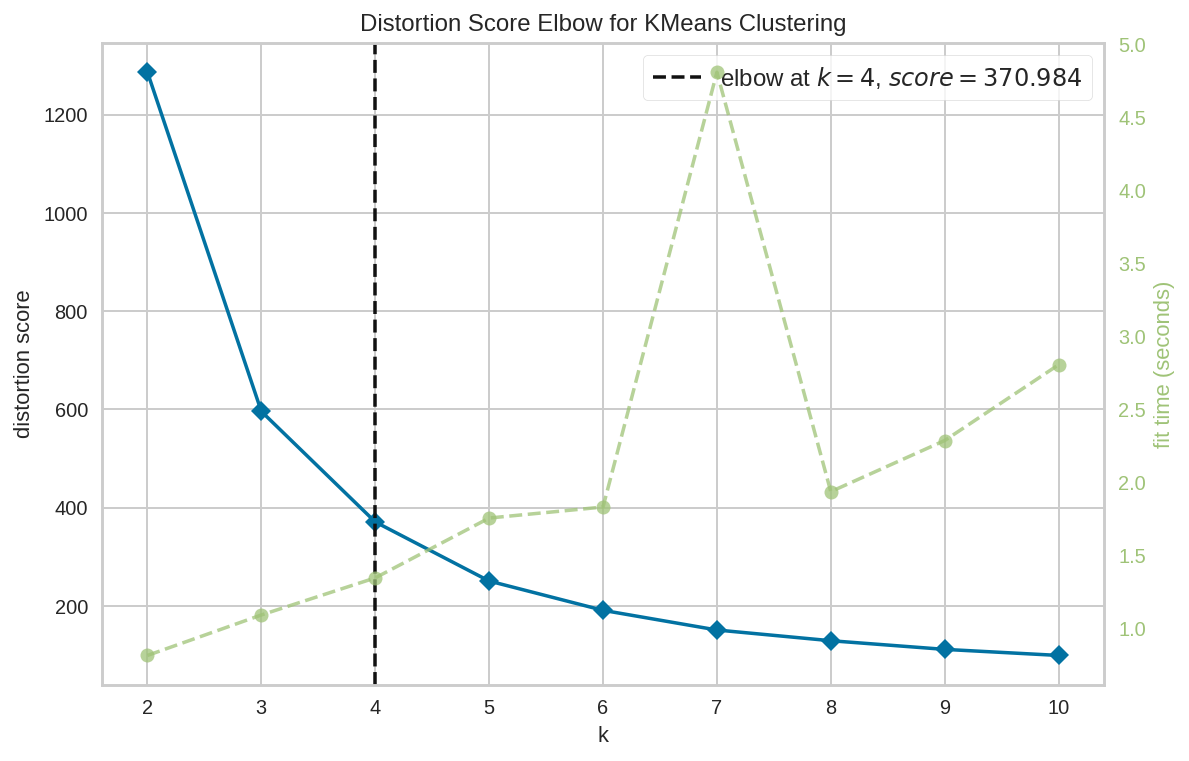

In [56]:
# elbow 방식을 이용하여 최적의 K를 탐색한다. 
# KELbowVisualizer 알고리즘을 통해 확인 가능하고, K=4일떄가 최적임을 알 수 있다. 

km = KMeans()
elbow = KElbowVisualizer(estimator=km, k=10)
elbow.fit(rfm_data_scaled)
elbow.show();

In [57]:
# 총 4개의 클러스터를 할당한다. 

km = KMeans(n_clusters=4, random_state=42)
clusters = km.fit_predict(rfm_data_scaled)

rfm_data_scaled['cluster'] = clusters
rfm_data_scaled

,R,F,M,cluster
0,0.159122,0.0,0.010385,2
1,0.163237,0.0,0.001990,2
2,0.743484,0.0,0.006310,1
3,0.447188,0.0,0.003192,0
4,0.401920,0.0,0.014409,0
...,...,...,...,...
94985,0.620027,0.0,0.151303,1
94986,0.366255,0.0,0.006190,0
94987,0.786008,0.0,0.008230,1
94988,0.170096,0.0,0.009784,2


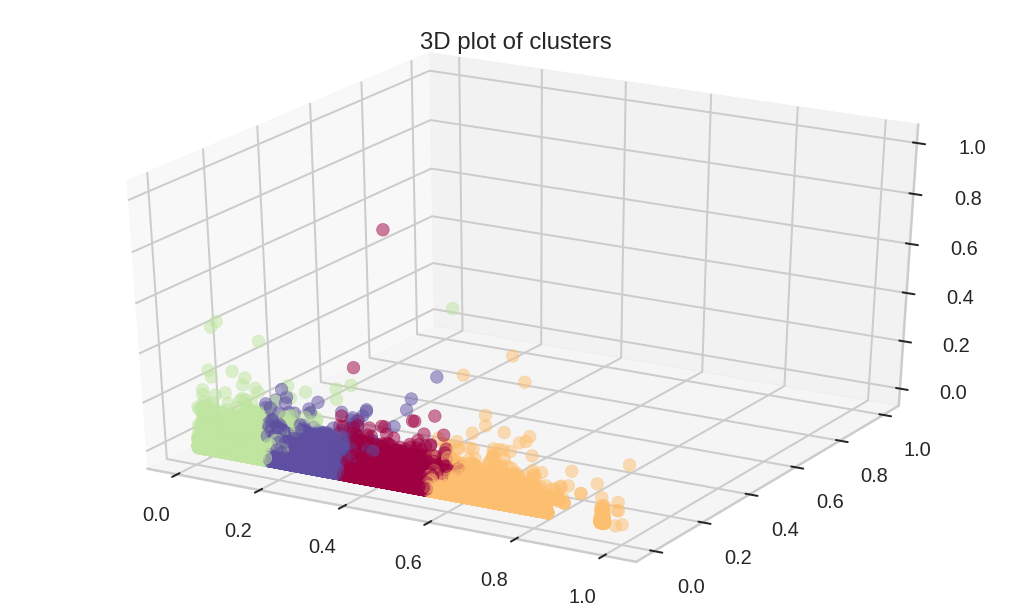

In [58]:
# 3차원 시각화로 클러스터링 상태를 확인한다. 

x = rfm_data_scaled['R'] 
y = rfm_data_scaled['F']
z = rfm_data_scaled['M']

fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111, projection='3d')
ax.scatter(x, y, z, s=40, c=rfm_data_scaled['cluster'], marker='o', alpha=0.5, cmap='Spectral')
ax.set_title('3D plot of clusters');

In [59]:
ds3['cluster'] = rfm_data_scaled['cluster']
ds3['cluster'].value_counts().sort_index()

0    24736
1    17009
2    25686
3    27559
Name: cluster, dtype: int64

### R,F,M에 대한 가중치 계산 

RFM 점수를 산출하기 위한 공식은 다음과 같다.

RFMi = w1 * Recency + w2 * Frequency + w3 * Monetary (제약조건 : SUM(w1, w2, w3) = 1)

각 클러스터의 통계량(평균, 표준편차)을 이용하여 각 그룹에 대한 변동계수를 구한 뒤, R,F,M의 가중치를 계산한다.

In [60]:
ds3.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,4,1,4,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4,1,1,2
2,0000f46a3911fa3c0805444483337064,542,1,86.22,1,1,2,1
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,2,1,1,0
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,2,1,4,0


In [61]:
tmp = ds3.pivot_table(index='cluster', values=['R', 'F', 'M'], aggfunc=['mean', 'std'])
tmp

mean                               std                       
                F           M           R         F           M          R
cluster                                                                   
0        1.032463  166.494560  318.849612  0.190425  230.149246  43.299176
1        1.025222  164.059273  489.027280  0.171146  242.307282  59.242338
2        1.039126  169.890037   66.931558  0.244518  238.071684  35.910791
3        1.035560  162.068577  188.382525  0.216286  201.424028  35.177576

In [62]:
# Recency = w1 
cv_r_0 = tmp[('std', 'R')][0] / tmp[('mean', 'R')][0]
cv_r_1 = tmp[('std', 'R')][1] / tmp[('mean', 'R')][1]
cv_r_2 = tmp[('std', 'R')][2] / tmp[('mean', 'R')][2]
cv_r_3 = tmp[('std', 'R')][3] / tmp[('mean', 'R')][3]

w_r = np.min([cv_r_0, cv_r_1, cv_r_2, cv_r_3]) / np.sum([cv_r_0, cv_r_1, cv_r_2, cv_r_3])
w_r

0.12358952692462812

In [63]:
# Frequency = w2 
cv_f_0 = tmp[('std', 'F')][0] / tmp[('mean', 'F')][0]
cv_f_1 = tmp[('std', 'F')][1] / tmp[('mean', 'F')][1]
cv_f_2 = tmp[('std', 'F')][2] / tmp[('mean', 'F')][2]
cv_f_3 = tmp[('std', 'F')][3] / tmp[('mean', 'F')][3]

w_f = np.min([cv_f_0, cv_f_1, cv_f_2, cv_f_3]) / np.sum([cv_f_0, cv_f_1, cv_f_2, cv_f_3])
w_f

0.2098384425367614

In [64]:
# Monetary = w3 
cv_m_0 = tmp[('std', 'M')][0] / tmp[('mean', 'M')][0]
cv_m_1 = tmp[('std', 'M')][1] / tmp[('mean', 'M')][1]
cv_m_2 = tmp[('std', 'M')][2] / tmp[('mean', 'M')][2]
cv_m_3 = tmp[('std', 'M')][3] / tmp[('mean', 'M')][3]

w_m = np.min([cv_m_0, cv_m_1, cv_m_2, cv_m_3]) / np.sum([cv_m_0, cv_m_1, cv_m_2, cv_m_3])
w_m

0.22582852386108065

In [65]:
# 모든 가중치의 합을 1로 만들도록 변환하여, 최종적으로 각 R, F, M에 대한 가중치를 구한다. 
W_R = w_r/(w_r + w_f + w_m) 
W_F = w_f/(w_r + w_f + w_m) 
W_M = w_m/(w_r + w_f + w_m) 

print('Weight of Recency : {}'.format(W_R))
print('Weight of Frequency : {}'.format(W_F))
print('Weight of Monetary : {}'.format(W_M))
print('Total sum of weight : {}'.format(np.sum([W_R, W_F, W_M])))

Weight of Recency : 0.22098898877400383
Weight of Frequency : 0.3752096668384456
Weight of Monetary : 0.40380134438755055
Total sum of weight : 1.0


### 고객별 RFM 점수에 따른 고객 등급화 
위에서 산출한 가중치를 이용하여, 아래와 같이 100점 만점 기준의 고객별 RFM 점수를 구한다. 

In [66]:
ds3['RFM_score'] = ds3['R_score'].astype(int) * W_R/5 * 100 \
+ ds3['F_score'].astype(int) * W_F/2 * 100 \
+ ds3['M_score'].astype(int) * W_M/5 * 100 

ds3.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score,cluster,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,4,1,4,2,68.743710
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4,1,1,2,44.515629
2,0000f46a3911fa3c0805444483337064,542,1,86.22,1,1,2,1,39.332317
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,2,1,1,0,35.676070
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,2,1,4,0,59.904150


RFM 점수는 아래와 같이 최저 31점부터 최대 100점까지 분포하고 있음을 알 수 있다. 

In [67]:
ds3.RFM_score.describe()

count    94990.000000
mean        56.833764
std         13.967271
min         31.256290
25%         47.408344
50%         56.247903
75%         67.980177
max        100.000000
Name: RFM_score, dtype: float64

quantile을 기준으로 5개의 그룹으로 나누었고, 그룹 1의 점수가 가장 높다. 

만약 개별 카테고리별로 고객별 RFM 점수를 계산하거나, 다른 도메인 지식에 근거한 기준으로 계산하여 등급화하는 것도 의미 있을 것으로 판단된다.

In [68]:
ds3['class'] = pd.qcut(ds3.RFM_score, 5, labels=[5,4,3,2,1]).astype(str)
ds3.head()

,customer_unique_id,R,F,M,R_score,F_score,M_score,cluster,RFM_score,class
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,4,1,4,2,68.743710,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,4,1,1,2,44.515629,4
2,0000f46a3911fa3c0805444483337064,542,1,86.22,1,1,2,1,39.332317,5
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62,2,1,1,0,35.676070,5
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89,2,1,4,0,59.904150,3


### 세일즈 분석  

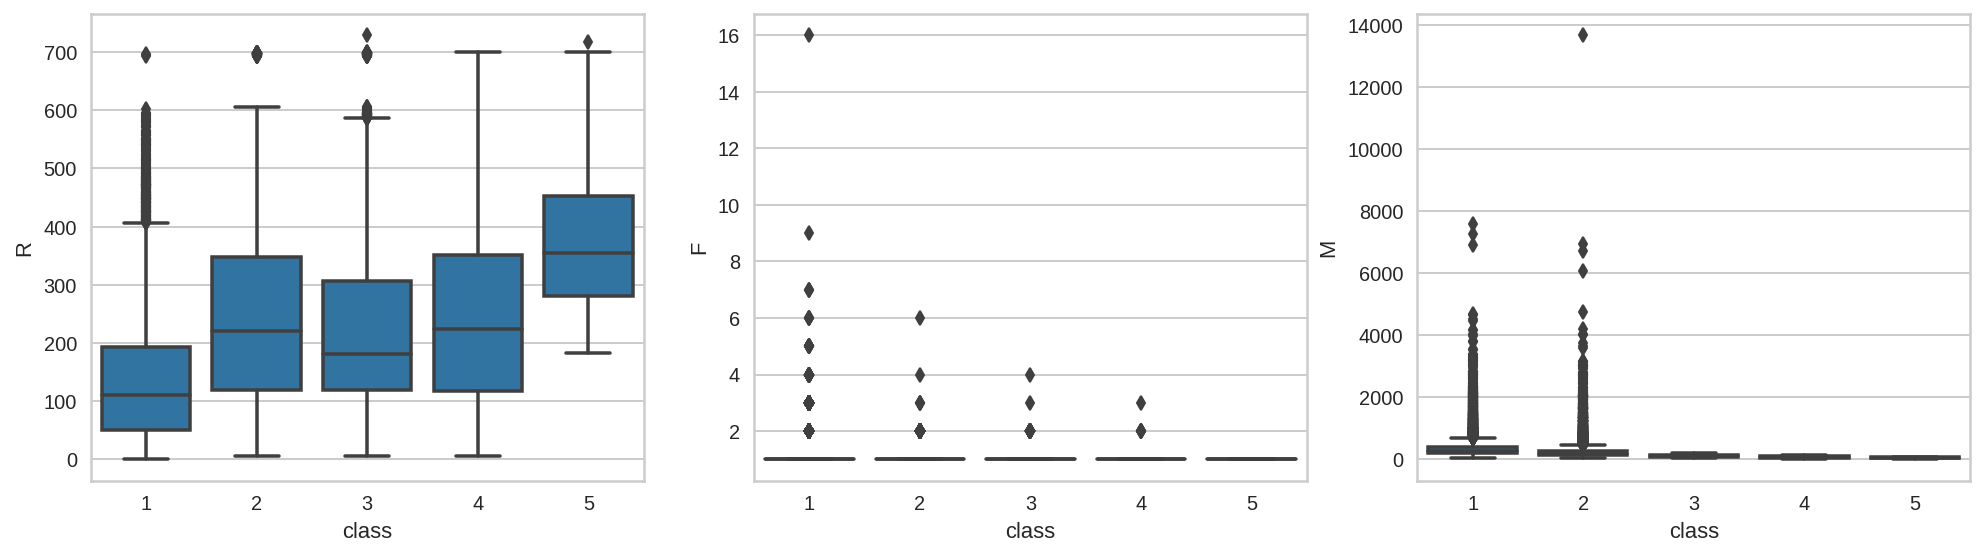

In [177]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for col, ax in zip(['R', 'F', 'M'], axes):
  sns.boxplot(x='class', y=col, data=ds3, color='tab:blue', order=['1', '2', '3', '4', '5'], ax=ax) 

* 1그룹의 Recency가 가장 높고, 나머지 그룹의 Recency는 비슷한 분포를 보인다. 

* 1그룹으로 갈수록 2회 이상 재구매 행태를 보인다. 

* 1,2그룹의 경우 2,000 브라질헤알 이상 금액의 구매자들이 있다. 

In [71]:
np.round(df_class[df_class['class'] == '1'].usertype.value_counts(normalize=True)*100, 1)

New         90.4
Existing     9.6
Name: usertype, dtype: float64

In [72]:
np.round(df_class[df_class['class'] == '2'].usertype.value_counts(normalize=True)*100, 1)

New         99.7
Existing     0.3
Name: usertype, dtype: float64

In [73]:
np.round(df_class[df_class['class'] == '3'].usertype.value_counts(normalize=True)*100, 1)

New         100.0
Existing      0.0
Name: usertype, dtype: float64

In [74]:
np.round(df_class[df_class['class'] == '4'].usertype.value_counts(normalize=True)*100, 1)

New         100.0
Existing      0.0
Name: usertype, dtype: float64

In [75]:
np.round(df_class[df_class['class'] == '5'].usertype.value_counts(normalize=True)*100, 1)

New    100.0
Name: usertype, dtype: float64

* class 1 vip 그룹을 제외한 나머지 그룹의 재결제율은 0%이다. 
* class 1 그룹이 주로 어떤 제품을 구매하는지 이해하고, 나머지 그룹의 재구매율을 높이기 위한 방안을 도출한다. 

In [136]:
growth = ds.merge(orders, how='left', on='order_id').merge(payments, how='left', on='order_id')
growth = growth.drop(['product_id', 'order_status'], axis=1)
growth = growth.merge(customers[['customer_id', 'customer_unique_id']], how='left', on='customer_id').drop('customer_id', axis=1)

In [137]:
growth['order_date'] = pd.to_datetime(growth.order_purchase_timestamp).dt.strftime('%Y-%m-%d')
growth = growth.drop('order_purchase_timestamp', axis=1)

In [138]:
growth['order_date'] = pd.to_datetime(growth['order_date'])
growth['year'] = growth.order_date.dt.year 
growth['quarter'] = growth.order_date.dt.quarter 
growth['purchase_fiscal'] = growth['quarter'].apply(lambda x : '1st half' if x ==1 or x==2 else '2st half')
growth['purchase_fiscal'] = growth['purchase_fiscal'] + '_' + growth['year'].astype(str).str.split('.', expand=True)[0]

In [139]:
growth = growth.dropna()
growth.head()

,order_id,product_category_name_english,payment_value,customer_unique_id,order_date,year,quarter,purchase_fiscal
0,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,72.19,871766c5855e863f6eccc05f988b23cb,2017-09-13,2017.0,3.0,2st half_2017
1,00018f77f2f0320c557190d7a144bdd3,pet_shop,259.83,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26,2017.0,2.0,1st half_2017
2,000229ec398224ef6ca0657da4fc703e,furniture_decor,216.87,3818d81c6709e39d06b2738a8d3a2474,2018-01-14,2018.0,1.0,1st half_2018
3,00024acbcdf0a6daa1e931b038114c75,perfumery,25.78,af861d436cfc08b2c2ddefd0ba074622,2018-08-08,2018.0,3.0,2st half_2018
4,00042b26cf59d7ce69dfabb4e55b4fd9,garden_tools,218.04,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04,2017.0,1.0,1st half_2017


In [140]:
growth = growth.merge(df_class[['customer_unique_id', 'class']], how='left', on='customer_unique_id')
growth = growth.groupby(['class', 'product_category_name_english','purchase_fiscal']).agg({'payment_value':'sum', 'order_id':'nunique'}).reset_index()
growth = growth[growth.purchase_fiscal.isin(['1st half_2018', '1st half_2017'])]

In [142]:
growth = growth.pivot(index=['class', 'product_category_name_english'], columns='purchase_fiscal', values=['payment_value','order_id']).reset_index()
growth.columns = ['class', 'cat_name', 'sales_1st_2017', 'sales_1st_2018', 'cnt_1st_2017', 'cnt_1st_2018'] 

In [143]:
growth['arppu_2017'] = growth['sales_1st_2017']/growth['cnt_1st_2017']
growth['arppu_2018'] = growth['sales_1st_2018']/growth['cnt_1st_2018']
growth['growth_rate(%)'] =( growth['sales_1st_2018'] - growth['sales_1st_2017'] )/ growth['sales_1st_2017']

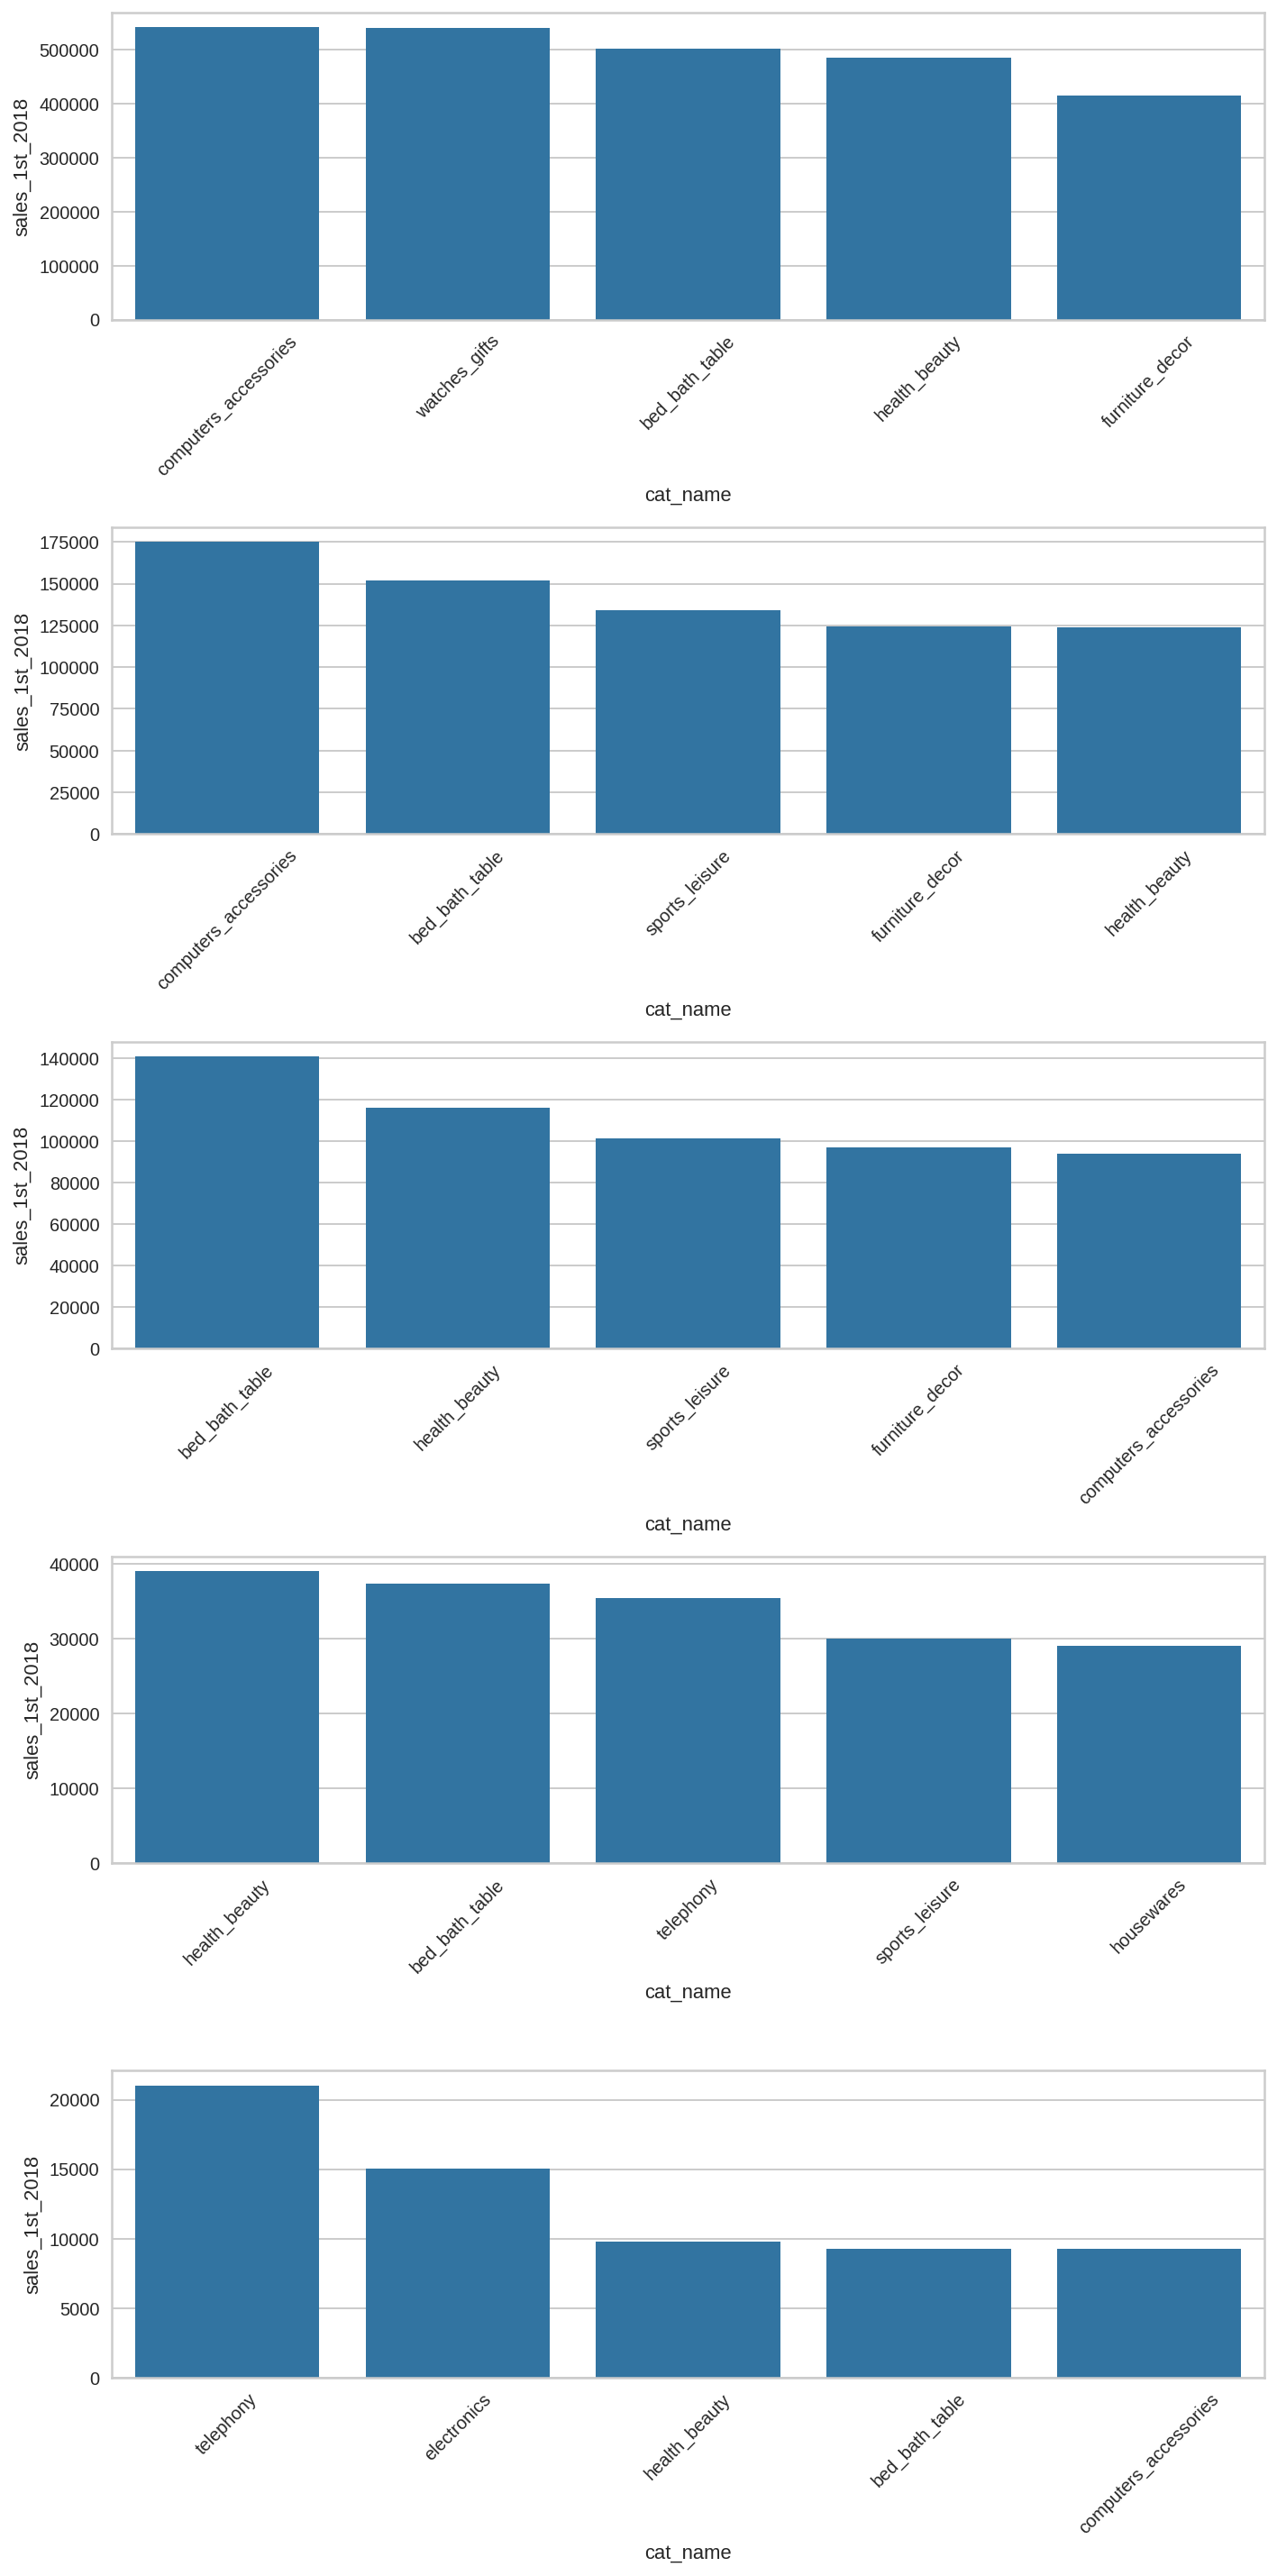

In [214]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))

for col, ax in zip(['1', '2', '3', '4', '5'], axes):
  sns.barplot(x='cat_name', y='sales_1st_2018', data=growth[growth['class']==col].sort_values(by='sales_1st_2018', ascending=False)[:5], color='tab:blue', ci=None, ax=ax)
  ax.tick_params(axis='x', labelrotation=45)
  plt.tight_layout() 

* 1 그룹의 경우 computers_accessories, watches_gifts, bed_bath_table 카테고리 등 구매력이 높다. 

* 2~3 그룹의 경우 1그룹과 상위 구매 카테고리가 비슷하지만, sports_leisure 카테고리가 주력 상품인 특징이 있다. 

* 4,5 그룹의 경우 구매금액이 낮고 health_beauty, telephony 카테고리 구매가 일어난다. 

* watches_gifts의 경우 최근 100일 이내 vip 구매자의 매출이 가장 높은 카테고리이다.  
  * 매출을 견인하기 위해 가장 주력해야 할 vip 상품으로 전략적인 상품 구성 및 vip 이벤트를 진행한다. 
* computer accessories는 1,2 그룹의 매출을 견인한 주요 카테고리이다. 
* sport_leisure의 경우 상위 그룹으로 갈수록 매출을 견인하는 주요 카테고리이다. 
  * 그룹별 구매 금액대가 다양한 품목으로 재구매를 유도 할 수 있는 상품 구성 및 이벤트를 진행한다.  

  

### ANOVA 
고객 등급화에 대한 통계적 유의성을 판단하기 위해 ANOVA를 수행하였다. 

아래와 같이 각 그룹의 등급화는 F값이 굉장히 크고, p value가 0에 가까우므로 통계적으로 유의함을 확인하였다. 

* ANOVA ( 분산 분석, Analysis Of Variance) 
  * 여러 집단의 **평균**이 다르다고 볼 수 있는지 알아보는 테스트 

* p-value(확률값, provavility value) 
  * p-value가 0.05보다 작으면 유의하다. 
  * 이 사건이 우연히 일어났을 가능성이 거의 없다고 보는 것 = 인과관계가 있다고 추정하는 것 

In [76]:
from scipy import stats 

In [77]:
cls1_r =  ds3[ds3['class']=='1']['R']
cls2_r =  ds3[ds3['class']=='2']['R']
cls3_r =  ds3[ds3['class']=='3']['R']
cls4_r =  ds3[ds3['class']=='4']['R']
cls5_r =  ds3[ds3['class']=='5']['R']

stats.f_oneway(cls1_r, cls2_r, cls3_r, cls4_r, cls5_r)

F_onewayResult(statistic=7197.618511385363, pvalue=0.0)

In [78]:
cls1_f =  ds3[ds3['class']=='1']['F']
cls2_f =  ds3[ds3['class']=='2']['F']
cls3_f =  ds3[ds3['class']=='3']['F']
cls4_f =  ds3[ds3['class']=='4']['F']
cls5_f =  ds3[ds3['class']=='5']['F']

stats.f_oneway(cls1_f, cls2_f, cls3_f, cls4_f, cls5_f)

F_onewayResult(statistic=2685.6444187743373, pvalue=0.0)

In [79]:
cls1_m =  ds3[ds3['class']=='1']['M']
cls2_m =  ds3[ds3['class']=='2']['M']
cls3_m =  ds3[ds3['class']=='3']['M']
cls4_m =  ds3[ds3['class']=='4']['M']
cls5_m =  ds3[ds3['class']=='5']['M']

stats.f_oneway(cls1_m, cls2_m, cls3_m, cls4_m, cls5_m)

F_onewayResult(statistic=8315.965227897488, pvalue=0.0)

## 결론 



* 문제 정의 
  * 2017년 서비스가 시작한 이후 Monthly Revenue가 지속적으로 성장하다가,
2017년 11월 최고점 판매 기록 이후 이후 매출이 정체되고 있다. 
  * 2017년 1분기 신규 유저가 급격하게 늘어난 이후, 월별 신규 유저의 비율은 지속적으로 감소하고 있다.
    * 월별 매출은 주로 신규 유저가 견인하는데, 매월 신규 유저 수가 감소한 것이 매출이 정체된 가장 큰 요인으로 보인다.
  * Monthly Retention이 1% 이하로 고객 유지율이 전반적으로 낮다. 특히 6개월 이후 재결제 유저의 잔존율은 17년 대비 18년 50% 이상 감소하였다.
    * 6개월 전 유입 유저의 리텐션이 다시 반등하는 모습을 보인다. 재결제 기간은 6개월로 유추 할 수 있다.
  * 기존 유저를 대상으로 한 재구매 전략과 신규 유저의 유입을 늘릴 수 있는 마케팅 전략을 모두 고려해야 한다. 단, 기존 유저의 잔존율이 매우 낮기 때문에 재구매 전략을 우선적으로 수립하자. 

* RFM 분석  
  * 1그룹의 Recency가 가장 높고, 나머지 그룹의 Recency는 비슷한 분포를 보인다. 
  * 1,2그룹에서 2회 이상 재구매를 하거나, 2,000 브라질헤알 이상 구매한 이상치 그룹이 존재한다. 
  * 1 그룹의 경우 computers_accessories, watches_gifts, bed_bath_table 카테고리 등 구매력이 높다. 
  * 2~3 그룹의 경우 1그룹과 상위 구매 카테고리가 비슷하지만, sports_leisure 카테고리가 주력 상품인 특징이 있다. 
  * 4,5 그룹의 경우 구매금액이 낮고 health_beauty, telephony 카테고리 구매가 일어난다. 

* 대응 방향 
  * watches_gifts의 경우 최근 100일 이내 vip 구매자의 매출이 가장 높은 카테고리이다.  
  * 매출을 견인하기 위해 가장 주력해야 할 vip 상품으로 전략적인 상품 구성 및 vip 이벤트를 진행한다. 
  * computer accessories는 1,2 그룹의 매출을 견인한 주요 카테고리이다. 
  * sport_leisure의 경우 상위 그룹으로 갈수록 매출을 견인하는 주요 카테고리이다. 
  * 그룹별 구매 금액대가 다양한 품목으로 재구매를 유도 할 수 있는 상품 구성 및 이벤트를 진행한다.
  * 이 때, 재결제 대상자는 6개월을 기준으로 산정한다. 

  




